In [1]:
# models.py
import numpy as np
from scipy import linalg
from copy import deepcopy
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA as SkCCA
from sklearn.cross_decomposition import PLSRegression as SkPLS
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter("ignore")

alphas = np.logspace(-4, 4, 20)
components = np.linspace(0., 1., 20)


def r_score(X, Y, multioutput='uniform_average'):
    """column-wise correlation coefficients"""

    assert multioutput in ('raw', 'raw_values', 'uniform_average',
                           'variance_weighted')
    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    assert len(X) >= 2
    np.testing.assert_equal(X.shape, Y.shape)

    R = np.zeros(X.shape[1])
    for idx, (x, y) in enumerate(zip(X.T, Y.T)):
        R[idx] = pearsonr(x, y)[0]

    if multioutput == 'uniform_average':
        R = R.mean()
    elif multioutput == 'variance_weighted':
        std = np.r_[X, Y].std(0)
        R = np.average(R, weights=std)
    return R


def rn_score(X, Y, scoring='r', multioutput='uniform_average'):
    assert scoring in ('r', 'r2')
    assert multioutput in ('raw', 'raw_values',
                           'uniform_average', 'variance_weighted')

    if scoring == 'r':
        return r_score(X, Y, multioutput=multioutput)

    elif scoring == 'r2':
        return r2_score(X, Y, multioutput=multioutput)


class B2B(BaseEstimator, RegressorMixin):
    def __init__(self, alphas=alphas,
                 independent_alphas=True, ensemble=None,
                 G='ridge_cv',
                 H='ridge_cv',
                 scoring='r'):
        self.alphas = alphas
        self.independent_alphas = independent_alphas
        self.ensemble = ensemble
        self.scoring = scoring
        self.__name__ = 'B2B'
        self.G = G
        self.H = H

    def fit(self, X, Y):
        import copy

        self.G_ = list()
        self.H_ = list()

        # Prepare ensembling
        if self.ensemble is None:
            ensemble = [(range(len(X)), range(len(X))), ]
        else:
            if isinstance(self.ensemble, int):
                ensemble = ShuffleSplit(self.ensemble)
            else:
                ensemble = self.ensemble
            ensemble = [split for split in ensemble.split(X)]

        # Ensembling loop
        for train, test in ensemble:

            # Fit decoder
            if self.G == 'ridge_cv':
                G, G_alpha, YG = ridge_cv(Y[train], X[train],
                                          self.alphas,
                                          self.independent_alphas)
                if len(X[train]) != len(X):
                    YG = Y @ G.T
            else:
                G = copy.deepcopy(self.G).fit(Y[train], X[train])
                YG = np.empty((len(Y), X.shape[1]))
                YG[test] = G.predict(Y[test])

            self.G_.append(G)


            # Fit encoder
            if self.H == 'ridge_cv':
                H, H_alpha, _ = ridge_cv(X[test], YG[test],
                                         self.alphas,
                                         self.independent_alphas)
            else:
                H = copy.deepcopy(self.H).fit(X[test], YG[test])
            self.H_.append(H)

        # Aggregate ensembling
        if self.G == 'ridge_cv':
            self.G_ = np.mean(self.G_, 0)
        if self.H == 'ridge_cv':
            self.H_ = np.mean(self.H_, 0)
        self.E_ = np.diag(self.H_)

        return self

    def fit_H(self, X, Y):

        assert hasattr(self, 'G_')

        YG = Y @ self.G_.T
        # Fit encoder
        if self.H == 'ridge_cv':
            self.H_, H_alpha, _ = ridge_cv(X, YG,
                                           self.alphas,
                                           self.independent_alphas)
        else:
            raise NotImplementedError


        # Aggregate ensembling
        self.E_ = np.diag(self.H_)
        return self

    def score(self, X, Y, scoring=None, multioutput='raw_values'):
        scoring = self.scoring if scoring is None else scoring
        if multioutput != 'raw_values':
            raise NotImplementedError
        if self.G == 'ridge_cv':
            # Transform with decoder
            YG = Y @ self.G_.T
        else:
            YG = np.mean([G.predict(Y) for G in self.G_], 0)
            
        # Make standard and knocked-out encoders predictions
        if self.H == 'ridge_cv':
            XH = X @ self.H_.T
        else:
            XH = np.mean([H.predict(X) for H in self.H_], 0)
        # Compute R for each column X
        return rn_score(YG, XH, 
                        scoring=scoring, multioutput='raw_values')


class UnbiasedB2B(B2B):

    def fit(self, X, Y):

        self.G_ = list()
        self.H_ = list()

        # Prepare ensembling
        if self.ensemble is None:
            ensemble = [(range(len(X)), range(len(X))), ]
        else:
            if isinstance(self.ensemble, int):
                ensemble = ShuffleSplit(self.ensemble)
            else:
                ensemble = self.ensemble
            ensemble = [split for split in ensemble.split(X)]

        # Ensembling loop
        ols = LinearRegression()
        for train, test in ensemble:

            # Fit decoder
            G, G_alpha, YG = ridge_cv(Y[train], X[train],
                                      self.alphas,
                                      self.independent_alphas)
            self.G_.append(G)

            # Fit encoder
            H = ols.fit(X[test], Y[test] @ G.T).coef_
            self.H_.append(H)

        # Aggregate ensembling
        self.G_ = np.mean(self.G_, 0)
        self.H_ = np.mean(self.H_, 0)
        self.E_ = np.diag(self.H_)

        return self

    def score(self, X, Y, scoring=None, multioutput='raw_values'):
        scoring = self.scoring if scoring is None else scoring
        if multioutput != 'raw_values':
            raise NotImplementedError
        # Transform with decoder
        YG = Y @ self.G_.T
        # Make standard and knocked-out encoders predictions
        XE = X @ np.diag(self.E_).T
        # Compute R for each column X
        return rn_score(YG, XE, scoring=scoring, multioutput='raw_values')

    
def ridge_cv(X, Y, alphas, independent_alphas=False, Uv=None):
    """ Similar to sklearn RidgeCV but
   (1) can optimize a different alpha for each column of Y
   (2) return leave-one-out Y_hat
   """
    if isinstance(alphas, (float, int)):
        alphas = np.array([alphas, ], np.float64)
    if Y.ndim == 1:
        Y = Y[:, None]
    n, n_x = X.shape
    n, n_y = Y.shape
    # Decompose X
    if Uv is None:
        U, s, _ = linalg.svd(X, full_matrices=0)
        v = s**2
    else:
        U, v = Uv
    UY = U.T @ Y

    # For each alpha, solve leave-one-out error coefs
    cv_duals = np.zeros((len(alphas), n, n_y))
    cv_errors = np.zeros((len(alphas), n, n_y))
    for alpha_idx, alpha in enumerate(alphas):
        # Solve
        w = ((v + alpha) ** -1) - alpha ** -1
        c = U @ np.diag(w) @ UY + alpha ** -1 * Y
        cv_duals[alpha_idx] = c

        # compute diagonal of the matrix: dot(Q, dot(diag(v_prime), Q^T))
        G_diag = (w * U ** 2).sum(axis=-1) + alpha ** -1
        error = c / G_diag[:, np.newaxis]
        cv_errors[alpha_idx] = error

    # identify best alpha for each column of Y independently
    if independent_alphas:
        best_alphas = (cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = np.transpose([cv_duals[b, :, i]
                              for i, b in enumerate(best_alphas)])
        cv_errors = np.transpose([cv_errors[b, :, i]
                                  for i, b in enumerate(best_alphas)])
    else:
        _cv_errors = cv_errors.reshape(len(alphas), -1)
        best_alphas = (_cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = cv_duals[best_alphas]
        cv_errors = cv_errors[best_alphas]

    coefs = duals.T @ X
    Y_hat = Y - cv_errors
    return coefs, best_alphas, Y_hat


class Forward():
    def __init__(self, alphas=alphas, independent_alphas=True,
                 scoring='r', multioutput='uniform_average'):
        self.alphas = alphas
        self.independent_alphas = independent_alphas
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'Forward'

    def fit(self, X, Y):
        # Fit encoder
        self.H_, H_alpha, _ = ridge_cv(X, Y, self.alphas,
                                       self.independent_alphas)

        self.E_ = np.sum(self.H_**2, 0)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        # Make standard and knocked-out encoders predictions
        XH = X @ self.H_.T
        # Compute R for each column of Y
        return rn_score(Y, XH, scoring=scoring, multioutput=multioutput)

    def predict(self, X):
        return X @ self.H_.T


class Backward():
    def __init__(self, alphas=alphas, independent_alphas=True,
                 scoring='r'):
        self.alphas = alphas
        self.independent_alphas = independent_alphas
        self.scoring = scoring
        self.__name__ = 'Backward'

    def fit(self, X, Y):
        # Fit encoder
        self.H_, H_alpha, _ = ridge_cv(Y, X, self.alphas,
                                       self.independent_alphas)

        self.E_ = np.sum(self.H_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput='raw_values'):
        scoring = self.scoring if scoring is None else scoring
        if multioutput != 'raw_values':
            raise NotImplementedError
        # Make standard and knocked-out encoders predictions
        YH = Y @ self.H_.T
        # Compute R for each column of Y
        return rn_score(X, YH, scoring=scoring, multioutput=multioutput)

    def predict(self, X):
        return 0


def canonical_correlation(model, X, Y, scoring, multioutput):
    """Score in canonical space"""

    # check valid model
    for xy in 'xy':
        for var in ('mean', 'std', 'rotations'):
            assert hasattr(model, '%s_%s_' % (xy, var))
    assert model.x_rotations_.shape[1] == model.y_rotations_.shape[1]

    # check valid data
    if Y.ndim == 1:
        Y = Y[:, None]
    if X.ndim == 1:
        X = X[:, None]
    assert len(X) == len(Y)

    # Project to canonical space
    X = X - model.x_mean_
    X /= model.x_std_
    X = np.nan_to_num(X, 0)
    XA = X @ model.x_rotations_

    Y = Y - model.y_mean_
    Y /= model.y_std_
    Y = np.nan_to_num(Y, 0)
    YB = Y @ model.y_rotations_

    return rn_score(XA, YB, scoring=scoring, multioutput=multioutput)


def validate_number_components(n, X, Y):
    n_max = min(X.shape[1], Y.shape[1])
    if n == -1:
        n = n_max
    elif n >= 0. and n < 1.:
        n = int(np.floor(n_max * n))
        n = 1 if n == 0 else n

    assert n == int(n) and n > 0 and n <= n_max
    return int(n)


class GridPLS(BaseEstimator, RegressorMixin):
    """Optimize n_components by minimizing Y_pred error"""
    def __init__(self, n_components=components, cv=5,
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.n_components = n_components
        self.cv = cv
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'GridPLS'

    def fit(self, X, Y):

        N = self.n_components
        if not isinstance(N, (list, np.ndarray)):
            N = [N, ]

        components = np.unique([validate_number_components(n, X, Y)
                                for n in N])
        # Optimize n_components on Y prediction!
        if len(components) > 1:
            models = GridSearchCV(SkPLS(), dict(n_components=components))
            best = models.fit(X, Y).best_estimator_
            self.n_components_ = best.n_components

            x_valid = range(X.shape[1])
            y_valid = range(Y.shape[1])
        else:
            best = PLS(n_components=components[0],
                       scoring=self.scoring,
                       multioutput=self.multioutput)
            best.fit(X, Y)
            self.n_components_ = best.n_components_
            x_valid = best.x_valid_
            y_valid = best.y_valid_

        self.x_mean_ = np.zeros(X.shape[1])
        self.x_std_ = np.zeros(X.shape[1])
        self.x_rotations_ = np.zeros((X.shape[1], self.n_components_))
        self.y_mean_ = np.zeros(Y.shape[1])
        self.y_std_ = np.zeros(Y.shape[1])
        self.y_rotations_ = np.zeros((Y.shape[1], self.n_components_))

        self.x_mean_[x_valid] = best.x_mean_
        self.x_std_[x_valid] = best.x_std_
        self.x_rotations_[x_valid, :] = best.x_rotations_
        self.y_mean_[y_valid] = best.y_mean_
        self.y_std_[y_valid] = best.y_std_
        self.y_rotations_[y_valid, :] = best.y_rotations_

        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)
    def transform(self, X):
        return self.best.transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).best.transform(X)


class GridCCA(BaseEstimator, RegressorMixin):
    """Optimize n_components by minimizing Y_pred error"""
    def __init__(self, n_components=components, cv=5,
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.n_components = n_components
        self.cv = cv
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'GridCCA'

    def fit(self, X, Y):

        N = self.n_components
        if not isinstance(N, (list, np.ndarray)):
            N = [N, ]
        components = np.unique([validate_number_components(n, X, Y)
                                for n in N])
        # Optimize n_components on Y prediction!
        if len(components) > 1:
            models = GridSearchCV(SkCCA(), dict(n_components=components))
            best = models.fit(X, Y).best_estimator_
            self.n_components_ = best.n_components
            x_valid = range(X.shape[1])
            y_valid = range(Y.shape[1])
        else:
            best = CCA(n_components=components[0],
                       scoring=self.scoring,
                       multioutput=self.multioutput)
            best.fit(X, Y)
            self.n_components_ = best.n_components_

            x_valid = best.x_valid_
            y_valid = best.y_valid_

        self.x_mean_ = np.zeros(X.shape[1])
        self.x_std_ = np.zeros(X.shape[1])
        self.x_rotations_ = np.zeros((X.shape[1], self.n_components_))
        self.y_mean_ = np.zeros(Y.shape[1])
        self.y_std_ = np.zeros(Y.shape[1])
        self.y_rotations_ = np.zeros((Y.shape[1], self.n_components_))

        self.x_mean_[x_valid] = best.x_mean_
        self.x_std_[x_valid] = best.x_std_
        self.x_rotations_[x_valid, :] = best.x_rotations_
        self.y_mean_[y_valid] = best.y_mean_
        self.y_std_[y_valid] = best.y_std_
        self.y_rotations_[y_valid, :] = best.y_rotations_

        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)
    def transform(self, X):
        return self.best.transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).best.transform(X)


class GridRegCCA(BaseEstimator, RegressorMixin):
    def __init__(self, alphas=np.logspace(-4, 4., 20), cv=5,
                 n_components=[-1, ],
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.alphas = alphas
        self.cv = cv
        self.scoring = scoring
        self.n_components = n_components
        self.multioutput = multioutput
        self.__name__ = 'GridRegCCA'

    def fit(self, X, Y):

        self.x_valid_ = np.where(X.std(0) > 0)[0]
        self.y_valid_ = np.where(Y.std(0) > 0)[0]
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]

        N = self.n_components
        if not isinstance(N, (list, np.ndarray)):
            N = [N, ]
        components = np.unique([validate_number_components(n, X, Y)
                                for n in N])
        grid = {'alpha': self.alphas,
                'n_components': components}

        # Optimize n_components on Y prediction!
        if np.prod(list(map(np.shape, grid.values()))) > 1:
            models = GridSearchCV(RegCCA(scoring=self.scoring,
                                         multioutput=self.multioutput),
                                  grid)
            best = models.fit(X, Y).best_estimator_
        else:
            best = RegCCA(alpha=grid['alpha'][0], n_components=components[0],
                          scoring=self.scoring, multioutput=self.multioutput)
            best.fit(X, Y)
        self.n_components_ = best.n_components
        self.alpha_ = best.alpha

        self.x_mean_ = best.x_mean_
        self.x_std_ = best.x_std_
        self.x_rotations_ = best.x_rotations_
        self.y_mean_ = best.y_mean_
        self.y_std_ = best.y_std_
        self.y_rotations_ = best.y_rotations_

        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):

        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)

    def transform(self, X):
        return self.best.transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).best.transform(X)

class CCA(SkCCA):
    """overwrite scikit-learn CCA to get scoring function in
       canonical space"""

    def __init__(self, n_components=-1,
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'CCA'
        super().__init__(n_components=n_components, tol=tol)

    def fit(self, X, Y):

        self.x_valid_ = np.where(X.std(0) > 0)[0]
        self.y_valid_ = np.where(Y.std(0) > 0)[0]
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]

        N = self.n_components
        self.n_components = validate_number_components(N, X, Y)
        super().fit(X, Y)
        self.n_components_ = self.n_components
        self.n_components = N
        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)

    def transform(self, X):
        return super().transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).transform(X)

    
class PLS(SkPLS):
    """overwrite scikit-learn PLSRegression to get scoring function in
       canonical space"""

    def __init__(self, n_components=-1,
                 scoring='r', multioutput='uniform_average', tol=1e-15):
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'PLS'
        super().__init__(n_components=n_components, tol=tol)

    def fit(self, X, Y):
        self.x_valid_ = np.where(X.std(0) > 0)[0]
        self.y_valid_ = np.where(Y.std(0) > 0)[0]
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]
        N = self.n_components
        self.n_components = validate_number_components(N, X, Y)
        super().fit(X, Y)
        self.n_components_ = self.n_components
        self.n_components = N
        self.E_ = np.sum(self.x_rotations_**2, 1)
        return self

    def score(self, X, Y, scoring=None, multioutput=None):
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]
        scoring = self.scoring if scoring is None else scoring
        multioutput = self.multioutput if multioutput is None else multioutput
        return canonical_correlation(self, X, Y,
                                     scoring, multioutput)

    def transform(self, X):
        return super().transform(X[:, self.x_valid_])
    
    def fit_transform(self, X, Y):
        return self.fit(X, Y).transform(X)


class RegCCA(CCA):
    """Wrapper to get sklearn API for Regularized CCA """
    def __init__(self, alpha=0., n_components=-1,
                 scoring='r', multioutput='uniform_average',
                 tol=1e-15):
        self.alpha = alpha
        self.n_components = n_components
        assert (n_components > 0) or (n_components == -1)
        self.tol = tol
        self.scoring = scoring
        self.multioutput = multioutput
        self.__name__ = 'RegCCA'

    def fit(self, X, Y):

        self.x_valid_ = np.where(X.std(0) > 0)[0]
        self.y_valid_ = np.where(Y.std(0) > 0)[0]
        X = X[:, self.x_valid_]
        Y = Y[:, self.y_valid_]

        # Set truncation
        dx, dy = X.shape[1], Y.shape[1]
        dz_max = min(dx, dy)
        dz = dz_max if self.n_components == -1 else self.n_components
        dz = min(dz, dz_max)
        self.n_components_ = dz
        self.x_rotations_ = np.zeros((dx, dz))
        self.y_rotations_ = np.zeros((dy, dz))

        # Preprocess
        self.x_std_ = X.std(0)
        self.y_std_ = Y.std(0)
        self.x_mean_ = X.mean(0)
        self.y_mean_ = Y.mean(0)

        X = (X - self.x_mean_) / self.x_std_
        Y = (Y - self.y_mean_) / self.y_std_

        # compute cca
        comps = self._compute_kcca([X, Y],
                                   reg=self.alpha, numCC=dz)
        self.x_rotations_ = comps[0]
        self.y_rotations_ = comps[1]
        self.E_ = np.sum(self.x_rotations_**2, 1)

        return self

    def _compute_kcca(self, data, reg=0., numCC=None):
        """Adapted from https://github.com/gallantlab/pyrcca

        Copyright (c) 2015, The Regents of the University of California
        (Regents). All rights reserved.

        Permission to use, copy, modify, and distribute this software and its
        documentation for educational, research, and not-for-profit purposes,
        without fee and without a signed licensing agreement, is hereby
        granted, provided that the above copyright notice, this paragraph and
        the following two paragraphs appear in all copies, modifications, and
        distributions. Contact The Office of Technology Licensing, UC Berkeley,
        2150 Shattuck Avenue, Suite 510, Berkeley, CA 94720-1620, (510)
        643-7201, for commercial licensing opportunities.

        Created by Natalia Bilenko, University of California, Berkeley.
        """

        kernel = [d.T for d in data]

        nDs = len(kernel)
        nFs = [k.shape[0] for k in kernel]
        numCC = min([k.shape[1] for k in kernel]) if numCC is None else numCC

        # Get the auto- and cross-covariance matrices
        crosscovs = [np.dot(ki, kj.T) for ki in kernel for kj in kernel]

        # Allocate left-hand side (LH) and right-hand side (RH):
        LH = np.zeros((sum(nFs), sum(nFs)))
        RH = np.zeros((sum(nFs), sum(nFs)))

        # Fill the left and right sides of the eigenvalue problem
        for i in range(nDs):
            RH[sum(nFs[:i]): sum(nFs[:i+1]),
               sum(nFs[:i]): sum(nFs[:i+1])] = (crosscovs[i * (nDs + 1)]
                                                + reg * np.eye(nFs[i]))

            for j in range(nDs):
                if i != j:
                    LH[sum(nFs[:j]): sum(nFs[:j+1]),
                       sum(nFs[:i]): sum(nFs[:i+1])] = crosscovs[nDs * j + i]

        LH = (LH + LH.T) / 2.
        RH = (RH + RH.T) / 2.

        maxCC = LH.shape[0]
        try:
            r, Vs = linalg.eigh(LH, RH, eigvals=(maxCC - numCC, maxCC - 1))
        except linalg.LinAlgError:  # noqa
            r = np.zeros(numCC)
            Vs = np.zeros((sum(nFs), numCC))

        r[np.isnan(r)] = 0
        rindex = np.argsort(r)[::-1]
        comp = []
        Vs = Vs[:, rindex]
        for i in range(nDs):
            comp.append(Vs[sum(nFs[:i]):sum(nFs[:i + 1]), :numCC])
        return comp


def score_knockout(model, X, Y, XY_train=None, scoring='r', fix_grid=True):
    assert isinstance(model, (CCA, PLS, GridCCA, GridPLS, RegCCA,
                              GridRegCCA, B2B, Forward, Backward))
    assert len(X) == len(Y)
    assert scoring in ('r', 'r2')
    is_b2b = isinstance(model, B2B)
    dim_x = X.shape[1]

    # Compute standard scores
    score_full = model.score(X, Y,
                             scoring=scoring,
                             multioutput='raw_values')
    score_delta = np.zeros(dim_x)

    # Compute knock out scores
    for f in range(dim_x):

        # Setup knockout matrix
        knockout = np.eye(dim_x)
        knockout[f] = 0

        model_ = model
        # refit the model
        if XY_train is not None:
            X_train, Y_train = XY_train
            model_ = deepcopy(model)
            if isinstance(model, (GridPLS, GridCCA, GridRegCCA)) and fix_grid:
                n = model.n_components_
                model_.n_components = -1 if n == X.shape[1] else n
            if is_b2b:
                model_.fit_H(X_train @ knockout, Y_train)
            else:
                model_.fit(X_train @ knockout, Y_train)

        # Score
        score_ko = model_.score(X @ knockout, Y,
                                scoring=scoring,
                                multioutput='raw_values')

        # Aggregate predicted dimensions
        if is_b2b:
            score_delta[f] = score_full[f] - score_ko[f]
        elif len(score_full) != len(score_ko):
            print('Different dims!')
            score_delta[f] = score_full.mean() - score_ko.mean()
        else:
            score_delta[f] = (score_full - score_ko).mean()

    return score_delta


class Manova():
    def __init__(self, statistics='F Value'):
        self.statistics = statistics
    
    def fit(self, X, Y):
        from statsmodels.multivariate.manova import MANOVA
        model = MANOVA(Y, X)
        manova_results = model.mv_test().summary_frame.reset_index()
        idx = manova_results.Statistic == "Wilks' lambda"
        self.coef_ = np.array([v for v in manova_results.loc[idx, 'F Value'].values])



class Composite():
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, Y):
        self.models_ = list()
        for y, model in zip(Y.T, self.models):
            self.models_.append(model.fit(X, y))
        return self

    def predict(self, X):
        Y_pred = [model.predict(X) for model in self.models_]
        return np.transpose(Y_pred)
    
def get_model(model_name, n_features, n_voxels):
    

    max_comp = min(n_voxels, n_features)
    comp_sweep = np.unique(np.floor(np.linspace(1, max_comp, 20))).astype(int)
    alpha_sweep = np.logspace(-4, 4, 20)
    models = dict(
        B2B=B2B(alpha_sweep),
        B2B_ensemble=B2B(alpha_sweep, ensemble=20),
        UnbiasedB2B=UnbiasedB2B(alpha_sweep, ensemble=KFold(3, shuffle=False)),  # FIXME use b2b H=LinearRegregrssion
        UnbiasedB2B_ensemble=UnbiasedB2B(alpha_sweep, ensemble=20),  # FIXME use b2b H=LinearRegregrssion
        Backward=Backward(alpha_sweep),
        Forward=Forward(alpha_sweep),
        CCA=GridCCA(comp_sweep),
        RegCCA=GridRegCCA(alpha_sweep, n_components=[max_comp]),
        PLS=GridPLS(comp_sweep),
        B2B_CCALinearSVR=B2B(alpha_sweep, 
                             ensemble=20,
                             G=make_pipeline(CCA(4), Composite([LinearSVR() for i in range(4)]))),
    )
    return models[model_name]
    
# if __name__ == '__main__':

#     X = np.zeros((10, 100))
#     Y = np.zeros((10, 200))
#     assert validate_number_components(0, X, Y) == 1
#     assert validate_number_components(1, X, Y) == 1
#     assert validate_number_components(.5, X, Y) == 50

#     def make_data():
#         n = 1000
#         dx = 4
#         dy = 5
#         X = np.random.randn(n, dx)
#         E = np.eye(dx)
#         E[2:] = 0
#         N = np.random.randn(n, dx)
#         N2 = np.random.randn(n, dy) / 10.
#         F = np.random.randn(dx, dy)
#         Y = (X @ E + N) @ F + N2

#         train, test = range(0, n, 2), range(1, n, 2)
#         return X, Y, train, test

#     X, Y, train, test = make_data()

#     models = (B2B, Forward, Backward, CCA, RegCCA, PLS,
#               GridCCA, GridPLS, GridRegCCA)
#     canonicals = (CCA, RegCCA, PLS, GridCCA, GridPLS, GridRegCCA)

#     for scoring in ('r', 'r2'):
#         for mo in ('uniform_average', 'variance_weighted'):
#             params = dict(scoring=scoring, multioutput=mo)

#             for model in models:
#                 if model in (B2B, Backward):
#                     model = model(scoring=scoring)
#                 else:
#                     model = model(scoring=scoring, multioutput=mo)
#                 model.fit(X[train], Y[train])
#                 assert len(model.E_) == X.shape[1]
#                 score = model.score(X[test], Y[test], multioutput='raw_values')

#                 if isinstance(model, canonicals):
#                     assert len(score) == model.n_components_
#                 elif isinstance(model, (B2B, Backward)):
#                     assert len(score) == X.shape[1]
#                 elif isinstance(model, Forward):
#                     assert len(score) == Y.shape[1]

#                 for fix_grid in (False, True):
#                     # assert np.mean(score) > .3
#                     score_delta = score_knockout(model, X[test], Y[test],
#                                                  scoring=scoring,
#                                                  fix_grid=fix_grid)
#                     assert len(score_delta) == X.shape[1]
#                     print(model.__name__, score_delta)
#                     score_delta = score_knockout(model, X[test], Y[test],
#                                                  (X[train], Y[train]),
#                                                  scoring=scoring,
#                                                  fix_grid=fix_grid)
#                     assert len(score_delta) == X.shape[1]
#                     print(model.__name__, score_delta)

#     for model in canonicals:
#         for n_components in (-1, 1, 2):
#             if model in (CCA, RegCCA, PLS):
#                 m = model(n_components)
#             else:
#                 m = model([n_components, ])
#             m.fit(X[train], Y[train])
#             assert len(m.E_) == X.shape[1]
#             score = m.score(X[test], Y[test], multioutput='raw_values')
#             assert len(score) == m.n_components_
#             print(model.__name__, score_delta)

In [2]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, norm, wilcoxon

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.metrics import make_scorer

import nibabel as nib
import nilearn
from nilearn import surface
from nilearn import plotting
from nilearn.decoding.searchlight import search_light
from nistats.design_matrix import make_first_level_design_matrix as make_design
from nistats.first_level_model import run_glm, FirstLevelModel
from nistats.contrasts import compute_contrast
from nistats.hemodynamic_models import compute_regressor

from wordfreq import zipf_frequency
import spacy

/private/home/jeanremi/.conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.



# Paths

In [3]:
deriv_path = pathlib.Path('/private/home/jeanremi/project/mous_fmri/fmriprep/')
data_path = pathlib.Path('/private/home/jeanremi/data/mous/raw/')

func_suffix = '_task-visual_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
func_fname = str(deriv_path / '%s' / 'func'/ ('%s' + func_suffix))

confounds_suffix = '_task-visual_desc-confounds_regressors.tsv'
confounds_fname = str(deriv_path / '%s' / 'func'/ ('%s' + confounds_suffix))

events_fname = str(data_path / '%s' / 'func' / ('%s' +  '_task-visual_events.tsv'))

In [4]:
def read_events(event_fname):
    # Read MRI events
    events = pd.read_csv(event_fname, sep='\t')

    # Add context: sentence or word list?
    contexts = dict(WOORDEN='word_list', ZINNEN='sentence')
    for key, value in contexts.items():
        sel = events.value.str.contains(key)
        events.loc[sel, 'context'] = value
        events.loc[sel, 'condition'] = value

    # Clean up MRI event mess
    sel = ~events.context.isna()
    start = 0
    context = 'init'
    for idx, row in events.loc[sel].iterrows():
        events.loc[start:idx, 'context'] = context
        start = idx
        context = row.context
    events.loc[start:, 'context'] = context

    # Add event condition: word, blank, inter stimulus interval etc
    conditions = (('50', 'pulse'), ('blank', 'blank'), ('ISI', 'isi'))
    for key, value in conditions:
        sel = events.value == key
        events.loc[sel, 'condition'] = value

    events.loc[events.value.str.contains('FIX '), 'condition'] = 'fix'

    # Extract words from file
    sel = events.condition.isna()
    words = events.loc[sel, 'value'].apply(lambda s: s.strip('0123456789 '))
    events.loc[sel, 'word'] = words

    # Remove empty words
    sel = (events.word.astype(str).apply(len) == 0) & (events.condition.isna())
    events.loc[sel, 'word'] = pd.np.nan
    events.loc[sel, 'condition'] = 'blank'
    events.loc[~events.word.isna(), 'condition'] = 'word'
    
    # Define sequence
    events.loc[events.word=='QUESTION', 'condition'] = 'question'
    events.loc[events.word=='QUESTION', 'word'] = np.nan
    words = events.query('condition=="word"')
    events['sequence'] = np.cumsum(events.condition=='fix')
    
    for s, words in events.query('condition=="word"').groupby('sequence'):
        events.loc[words.index, 'word_position'] = range(len(words))
    
    # Fix bids
    events['trial_type'] = events['type']

    return events

# GLM: one Subject

In [5]:
# subject = 'sub-V1002'

# img = nib.load(func_fname % (subject, subject))

# events = read_events(events_fname % (subject, subject))

# confounds = pd.read_csv(confounds_fname % (subject, subject), sep='\t', index_col=None)

# confounds = confounds.fillna(method='ffill').fillna(method='bfill')

# model = FirstLevelModel(t_r=2., n_jobs=12)
# model.fit(img, events, confounds)

# p001_unc = norm.isf(0.001)
# zmap = model.compute_contrast('Picture-Response')
# plotting.plot_glass_brain(zmap,
#                           colorbar=False,
#                           threshold=p001_unc,
#                           plot_abs=False)

# Across subjects

In [6]:
from nilearn.decoding.searchlight import GroupIterator
from joblib import Parallel, delayed
import warnings

def searchlight_multiscore(X, Y, estimator, A, cv=3, scorer=None,
                           groups=None, n_jobs=1, verbose=1,
                           direction='decod'):
    """Same as nilearn but acces multidimensional scoring
    scorer is a callable"""
    group_iter = GroupIterator(A.shape[0], n_jobs)
    parallel = Parallel(n_jobs=n_jobs, verbose=verbose)
    iter_func = delayed(_group_iter_searchlight) 
    scores = parallel(iter_func(A.rows[idx], estimator, X, Y, 
                                groups, scorer, cv, direction) 
                      for idx in group_iter)
    return np.concatenate(scores, axis=0)

def _group_iter_searchlight(A, estimator, X, Y, groups, scorer, cv, direction):
    if isinstance(cv, int):
        cv = KFold(cv)
    all_scores = list()
    for row in A:
        if direction == 'decod':
            x, y = X[:, row], Y
        else:
            x, y = X, Y[:, row]
        
        if x.std(0).sum()==0 or y.std(0).sum()==0:
            all_scores.append(None)
            continue
        try:
            scores = list()
            for train, test in cv.split(x):
                estimator.fit(x[train], y[train])
                if scorer == 'knockout':
                    score = score_knockout(estimator, x[test], y[test])
                elif isinstance(scorer, str):
                    score = getattr(estimator, scorer)
                elif scorer is not None:
                    y_pred = estimator.predict(x[test])
                    score = scorer(y[test], y_pred)
                else:
                    score = estimator.score(x[test], y[test])
                scores.append(score)
        except:
            all_scores.append(None)
            continue
        all_scores.append(np.mean(scores, 0))
    
    # deal with missing data
    shapes = [np.shape(s) for s in all_scores if s is not None]
    assert len(set(shapes)) == 1
    for i, scores in enumerate(all_scores):
        if scores is None:
            all_scores[i] = np.zeros(shapes[0]) * np.nan
    return np.array(all_scores)

In [7]:
def correlate(X, Y):
    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    X = X - X.mean(0)
    Y = Y - Y.mean(0)
    SX2 = (X**2).sum(0)**.5
    SY2 = (Y**2).sum(0)**.5
    SXY = (X * Y).sum(0)
    return SXY / (SX2 * SY2)

def scale(X):
    shape = X.shape
    if len(shape) == 1:
        X = X[:, None]
    X = X - np.nanmean(X, 0, keepdims=True)
    std = np.nanstd(X, 0, keepdims=True)
    non_zero = np.where(std>0)
    X[:, non_zero] /= std[non_zero]
    X[np.isnan(X)] = 0
    X[~np.isfinite(X)] = 0
    
    return X.reshape(shape)

def convolve_events(events, frame_times, hrf_model='glover'):
    
    # Define potential causal factors
    events = events.query('condition=="word"')
    
    word_freq = events.word.apply(lambda w: zipf_frequency(w, 'nl'))
    word_length = events.word.apply(len)

    nlp = spacy.load("nl_core_news_sm")
    pos = events.word.apply(lambda w: nlp(w)[0].pos_ in ('VERB', 'ADJ', 'NOUN', 'ADV'))
    
    regressors = dict(
        #word=np.ones(len(events)),
        word_length=scale(word_length.values),
        word_freq=scale(word_freq.values),
        word_function=scale(pos.values),
        dummy=scale(word_length.values)+scale(word_freq.values)+np.random.randn(len(events)),
    )

    # Convolve then with standard HRF
    reg_signals = list()
    reg_names = list()
    for name, values in regressors.items():

        signal, name_ = compute_regressor(
            np.c_[events.onset, np.ones(len(events)), values].T,
            hrf_model=hrf_model, 
            frame_times=frame_times,
            oversampling=16)

        reg_signals.append(signal)
        reg_names.extend([name + n.split('cond')[1] for n in name_])
    reg_signals = np.concatenate(reg_signals, 1)
    
    return reg_signals, reg_names

In [19]:
def main(subject, remove_confounds=False):

    # Read Bold
    files = [f for f in os.listdir(deriv_path / subject / 'func')
             if f.endswith('-preproc_bold.nii.gz')
             and '_task-visual_space-MNI152' in f]
    assert len(files)
    img = nib.load(str(deriv_path / subject / 'func' / files[0]))
    
    # Read events and convolve with HRF response
    tr = 2.
    frame_times = np.arange(img.shape[-1]) * tr
    events = read_events(events_fname % (subject, subject))
    reg_signals, reg_names = convolve_events(events, 
                                             frame_times, 
                                             hrf_model='glover')
    
    # Prepare linear modeling
    estimator = make_pipeline(StandardScaler(), 
                              RidgeCV(np.logspace(-2, 8, 20)))
    cv = KFold(5, shuffle=False)
    
    # Loop across hemisphere
    fsaverage = nilearn.datasets.fetch_surf_fsaverage()
    out = dict()
    for hemi in ('left', ): # 'right'
        
        # Volume to surface
        mesh = fsaverage['pial_%s' % hemi]
        
        radius = 8.
        bold = surface.vol_to_surf(img, mesh, radius=radius).T
        bold = scale(bold)
        mesh = fsaverage['infl_%s' % hemi]
        coords, _ = surface.load_surf_mesh(mesh)
        radius = 8.
        nn = neighbors.NearestNeighbors(radius=radius)
        A = nn.fit(coords).radius_neighbors_graph(coords).tolil()

        nn = neighbors.NearestNeighbors(radius=2.)
        A_small = nn.fit(coords).radius_neighbors_graph(coords).tolil()

        # Remove confounds variable from bold signal
        if remove_confounds:
            keys = ['csf', 'white_matter']
            keys.extend(['trans_' + x for x in 'xyz'])
            keys.extend(['rot_' + x for x in 'xyz'])
            keys.extend(['trans_%s_derivative1' % x for x in 'xyz'])
            keys.extend(['rot_%s_derivative1' % x for x in 'xyz'])

            confounds = pd.read_csv(confounds_fname % (subject, subject), 
                                    sep='\t', index_col=None)
            confounds = confounds[keys].fillna(method='ffill').fillna(method='bfill')
            confounds = scale(confounds.values)

            bold_pred = cross_val_predict(estimator,
                                          X=confounds,
                                          y=bold,
                                          cv=cv,
                                          n_jobs=-1)
            bold = scale(bold - bold_pred)
            
        # Get manova small
        scores = searchlight_multiscore(X=scale(reg_signals),
                                Y=bold,
                                estimator=Manova(),
                                A=A_small,
                                cv=cv,
                                scorer='coef_',
                                direction='encod',
                                n_jobs=-1)
        for score, name in zip(scores.T, reg_names):
            out['_'.join(('Manova_small', hemi, name))] = score
            
        # Get manova
        scores = searchlight_multiscore(X=scale(reg_signals),
                                Y=bold,
                                estimator=Manova(),
                                A=A,
                                cv=cv,
                                scorer='coef_',
                                direction='encod',
                                n_jobs=-1)
        for score, name in zip(scores.T, reg_names):
            out['_'.join(('Manova', hemi, name))] = score
        
            
        # Get encoding coefficients
        betas = LinearRegression().fit(X=reg_signals, 
                                       y=bold).coef_
        for beta, name in zip(betas.T, reg_names):
            out['betas_%s_%s' % (hemi, name)] = beta

        # Get Encoding scores
        for idx, name in enumerate(reg_names):
            scores = list()
            for train, test in cv.split(bold):
                estimator.fit(reg_signals[train, idx][:, None], bold[train])
                bold_pred = estimator.predict(reg_signals[test, idx][:, None])
                r = correlate(bold[test], bold_pred)
                scores.append(r)
            out['encod_%s_%s' % (hemi, name)] = np.mean(scores, 0)

        # Get decoding scores
        scores = searchlight_multiscore(X=bold,
                                        Y=scale(reg_signals), 
                                        estimator=estimator,
                                        A=A,
                                        cv=cv,
                                        scorer=correlate, 
                                        n_jobs=-1)

        for score, name in zip(scores.T, reg_names):
            out['decod_%s_%s' % (hemi, name)] = score
        
        # B2b unbiased E_hat 
        model = get_model('UnbiasedB2B', reg_signals.shape[1], A.sum(1).min())
        model.ensemble = cv
        scores = searchlight_multiscore(X=scale(reg_signals),
                                        Y=bold,
                                        estimator=model,
                                        A=A,
                                        cv=cv,
                                        scorer='E_',
                                        direction='encod',
                                        n_jobs=-1)
        for score, name in zip(scores.T, reg_names):
            out['_'.join(('UnbiasedB2B_betas', hemi, name))] = score

        # paper models
        models = ('Forward', 'Backward', 
                  'PLS', 
                  'RegCCA', #'CCA',
                  'B2B', 'B2B_ensemble',#'UnbiasedB2B',
                  'B2B_CCALinearSVR',
                 )
        
        
        for model_name in models:
            print(model_name)
            model = get_model(model_name, reg_signals.shape[1], A.sum(1).min())
            scores = searchlight_multiscore(X=scale(reg_signals),
                                            Y=bold,
                                            estimator=model,
                                            A=A,
                                            cv=cv,
                                            scorer='knockout',
                                            direction='encod',
                                            n_jobs=-1)

            for score, name in zip(scores.T, reg_names):
                out['_'.join((model_name, hemi, name, 'knockout'))] = score
                
            if model_name not in ('Forward', 'Backward'):
                continue
            scores = searchlight_multiscore(X=scale(reg_signals),
                                            Y=bold,
                                            estimator=model,
                                            A=A,
                                            cv=cv,
                                            scorer=None,
                                            direction='encod',
                                            n_jobs=-1)
            # FIXME: for all but B2B, there is only one full score
            if scores.ndim == 1:
                scores = np.concatenate([scores[:, None]] * reg_signals.shape[1], axis=1)
                
            for score, name in zip(scores.T, reg_names):
                out['_'.join((model_name, hemi, name))] = score
        
    return out

In [9]:
# subject = 'sub-V1001'
# out = mini(subject, False)

In [10]:
# fsaverage = nilearn.datasets.fetch_surf_fsaverage()
# hemi = 'left'
# var = 'word_freq'
# plotting.plot_surf_stat_map(
#     stat_map=out['_'.join(('encod', hemi, var))],
#     surf_mesh=fsaverage['infl_%s' % hemi], 
#     hemi=hemi,
#     cmap=cmap,
# );

In [20]:
from submitit import AutoExecutor

subjects = sorted([f.split('.html')[0] for f in os.listdir('fmriprep')
                   if f[:3] == 'sub' and f.endswith('.html')])
subjects = [s for s in subjects if 'sub-V' in s]
executor = AutoExecutor('b2b_results/')
executor.update_parameters(timeout_min=60*10,
                           slurm_partition='learnfair,scavenge,uninterrupted',
                           slurm_constraint='pascal',
                           mem_gb=128,
                           slurm_cpus_per_task=10,
                           gpus_per_node=1)
jobs = executor.map_array(main, subjects)

In [48]:
results = pd.DataFrame([j.results()[0] 
                        for j in jobs if j.state=='COMPLETED'])

In [23]:

def add_colorbar(figure, axes, vmax, cmap, threshold=None):
    from matplotlib.colors import Normalize, LinearSegmentedColormap
    from matplotlib.cm import ScalarMappable
    from matplotlib.colorbar import make_axes
    
    vmin = -vmax
    our_cmap = plt.get_cmap(cmap)
    norm = Normalize(vmin=vmin, vmax=vmax)

    nb_ticks = 5
    ticks = np.linspace(vmin, vmax, nb_ticks)
    bounds = np.linspace(vmin, vmax, our_cmap.N)

    if threshold is not None:
        cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
        # set colors to grey for absolute values < threshold
        istart = int(norm(-threshold, clip=True) *
                     (our_cmap.N - 1))
        istop = int(norm(threshold, clip=True) *
                    (our_cmap.N - 1))
        for i in range(istart, istop):
            cmaplist[i] = (0.5, 0.5, 0.5, 1.)
        our_cmap = LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, our_cmap.N)

    # we need to create a proxy mappable
    proxy_mappable = ScalarMappable(cmap=our_cmap, norm=norm)
    # proxy_mappable.set_array(surf_map_faces)
    cax, kw = make_axes(axes, location='right', fraction=.1,
                        shrink=.6, pad=.0)
    cbar = figure.colorbar(
        proxy_mappable, cax=cax, ticks=ticks,
        boundaries=bounds, spacing='proportional',
        format='%.2g', orientation='vertical')

In [24]:
def plot(data, hemi='left', threshold=None, cmap='cold_hot', **kwargs):
    fig, ax = plt.subplots(1, figsize=[4.5, 5], subplot_kw={'projection': '3d'}, dpi=150)
    

    coords, verts = surface.load_surf_mesh(fsaverage['infl_%s' % hemi])
    coords2 = coords[:, [2, 1, 0]]
    coords2[:, 2] *= -1
    coords2[:, 2] -= 120
             
    xlim, ylim, zlim = zip(np.r_[coords, coords2].min(0), 
                           np.r_[coords, coords2].max(0))
    opt = dict(threshold=threshold,
               view='lateral',
               cmap=cmap,
               colorbar=False,
               bg_map=fsaverage['sulc_%s' % hemi])
    for k, v in kwargs.items():
        opt[k] = v
    
    
    for view in (coords2, coords):
        plotting.plot_surf_stat_map(stat_map=data,
                                    surf_mesh=(view, verts),
                                    axes=ax, 
                                    **opt)
        ax.set_xlim(*xlim)
        ax.set_ylim(ylim[0]*1.1, ylim[1]*1.1)
        ax.set_zlim(*zlim)
        
    # desaturate cortex
    from matplotlib.collections import PolyCollection

    for poly in ax.get_children():
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        if not isinstance(poly, Poly3DCollection):
            continue
        facecolors = poly._facecolors[:, :3]
        idx = np.where(np.apply_along_axis(lambda r: len(set(r)), 1, facecolors)==1)[0]
        poly._facecolors[idx, :3] /= 3.
        poly._facecolors[idx, :3] += .2

    # add colorbar
    vmax = np.nanmax(data) if 'vmax' not in kwargs.keys() else kwargs['vmax']
    add_colorbar(fig, ax, vmax, cmap=cmap, threshold=threshold)
    
    return fig

def fig_to_img(fig):
    from matplotlib.backends.backend_agg import FigureCanvasAgg
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
    return img.reshape(int(height), int(width), 3)

def crop(img):
    white = np.mean(img, 2) != 255
    first_row = np.where(white.sum(1))[0][0] - 10
    last_row = np.where(white[::-1].sum(1))[0][0] - 10
    first_column = np.where(white.sum(0))[0][0] - 10
    return img[first_row:-last_row][:, first_column:]

In [25]:
from matplotlib.colors import LinearSegmentedColormap
import colorcet
black = 10
colors = np.r_[colorcet.cm.fire(np.linspace(.95, 0, 128-black//2))[:, [2, 1, 0, 3]],
               np.c_[np.zeros((black, 3)), np.ones((black, 1))],
               colorcet.cm.fire(np.linspace(0, .95, 128-black//2))]
luminosity = (1 - np.clip(np.linspace(-5, 5, len(colors))**2, 0, 1)) ** 2
colors[:, :3] = np.clip(colors[:, :3] + luminosity[:, None]/2., 0, 1)
cmap = LinearSegmentedColormap.from_list('ice_fire', colors)
# plt.matshow(np.random.randn(100, 100), cmap=cmap, vmin=-4, vmax=4)
# plt.colorbar()

In [26]:
fsaverage = nilearn.datasets.fetch_surf_fsaverage()

word_length
word_freq
word_function
dummy


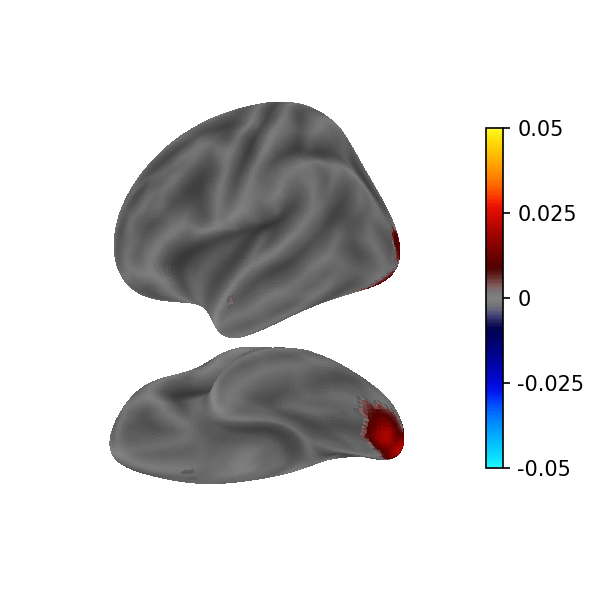

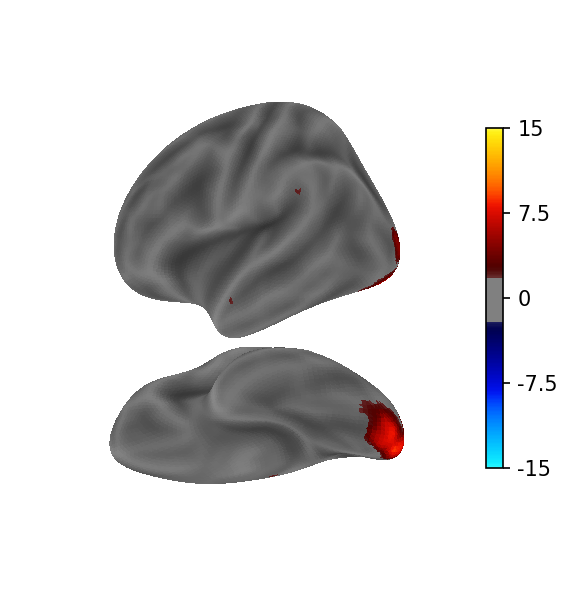

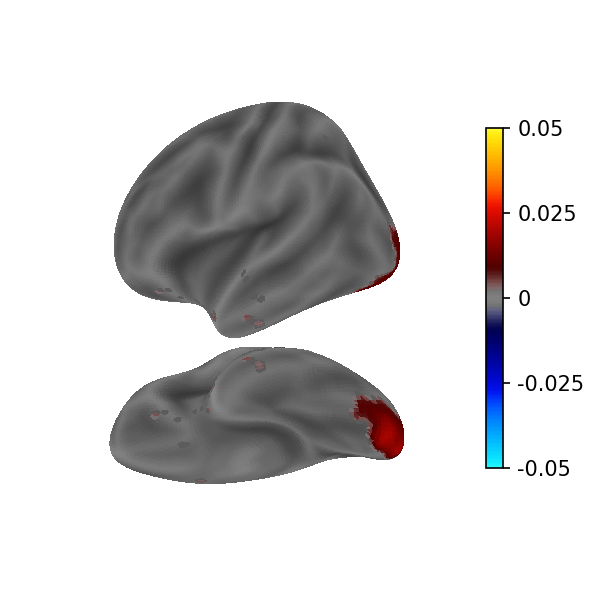

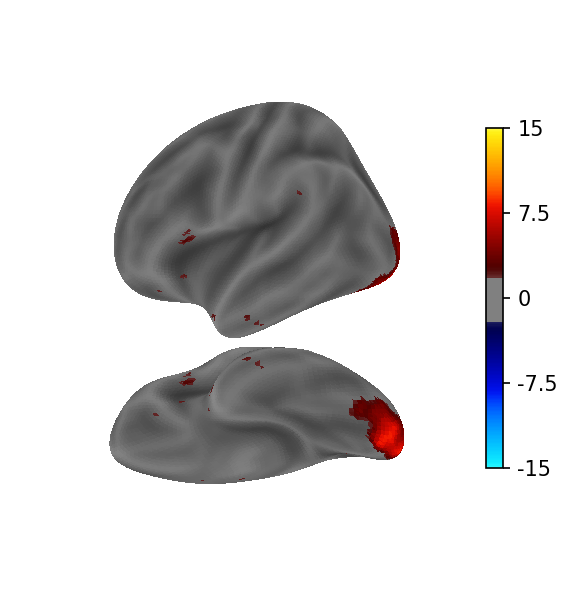

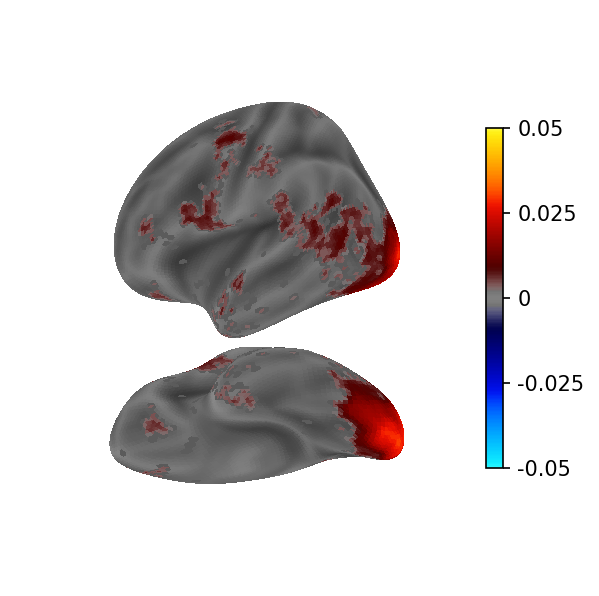

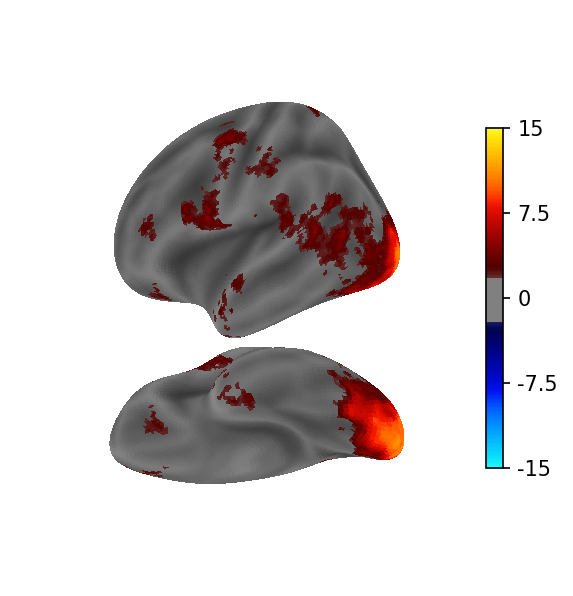

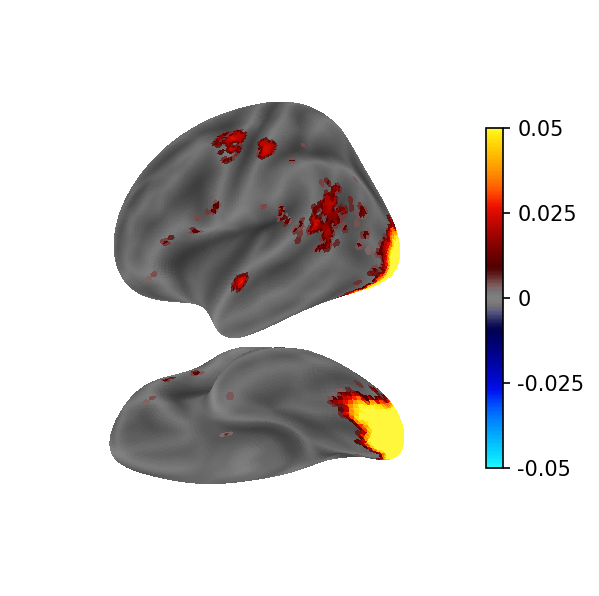

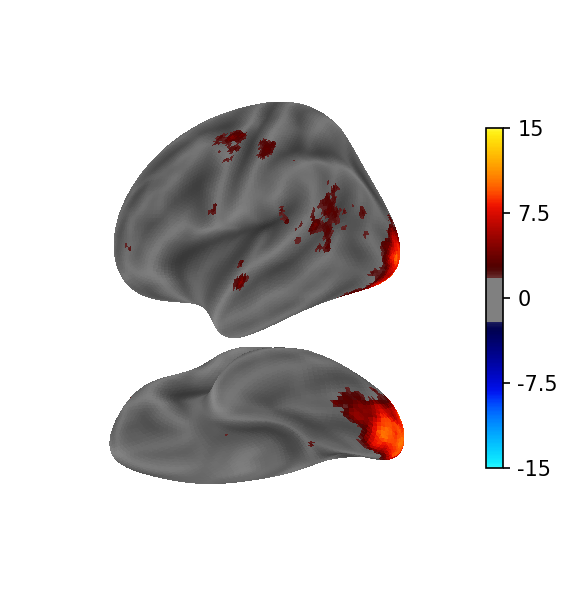

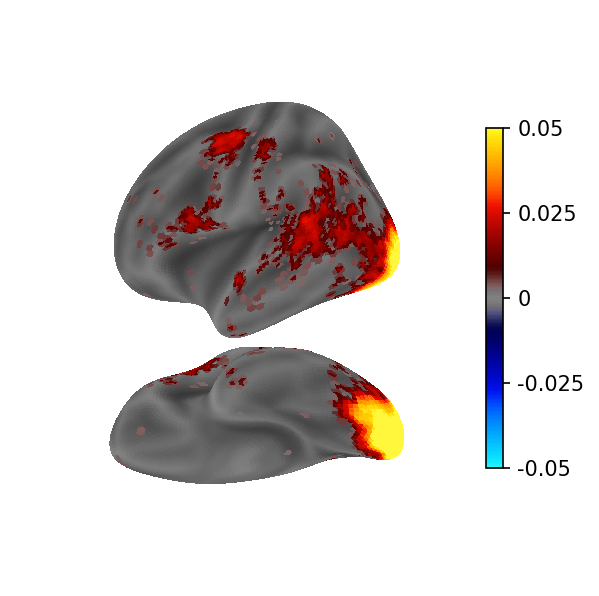

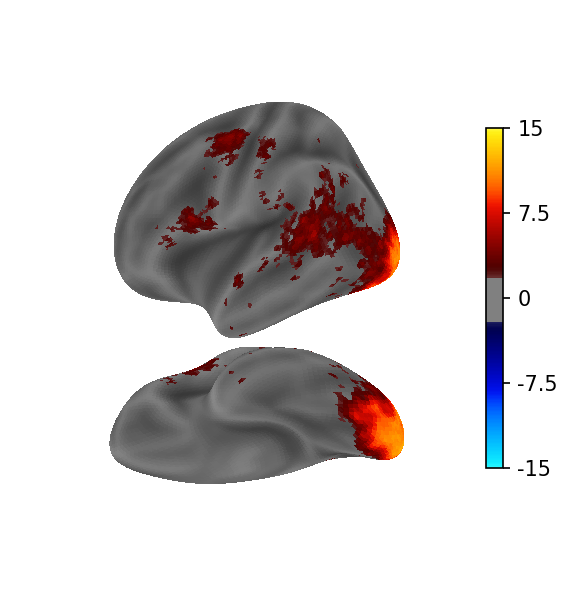

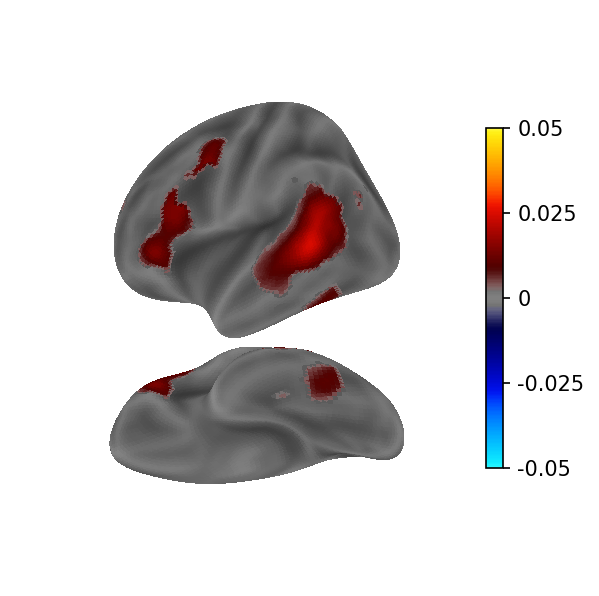

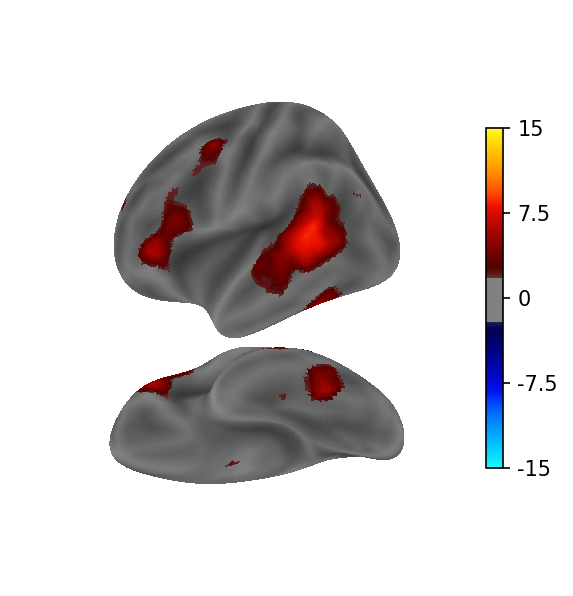

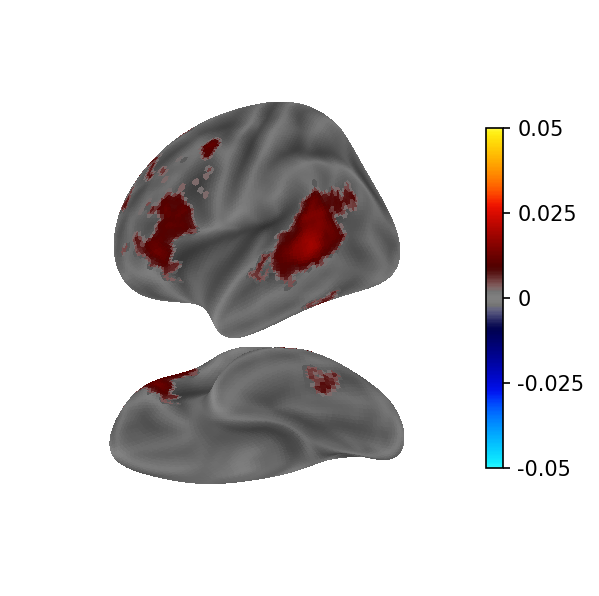

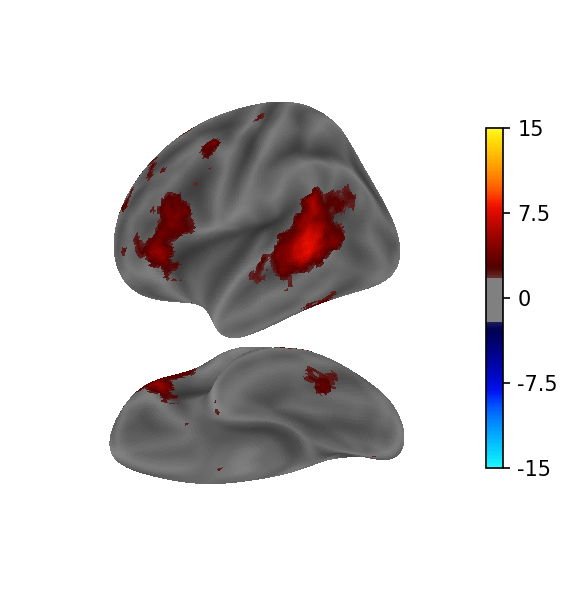

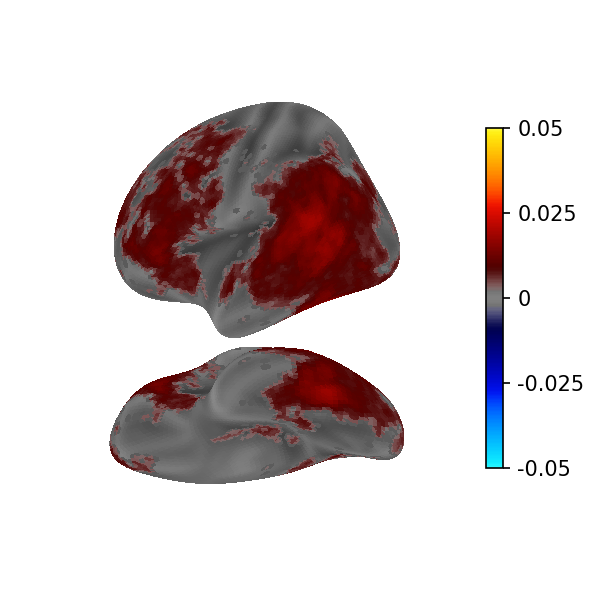

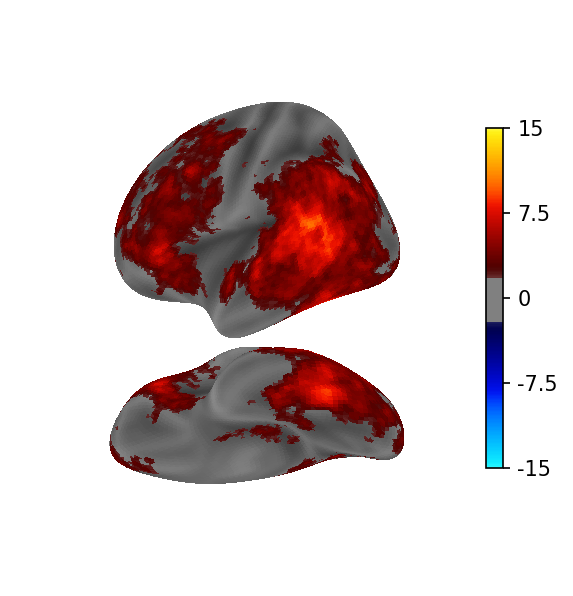

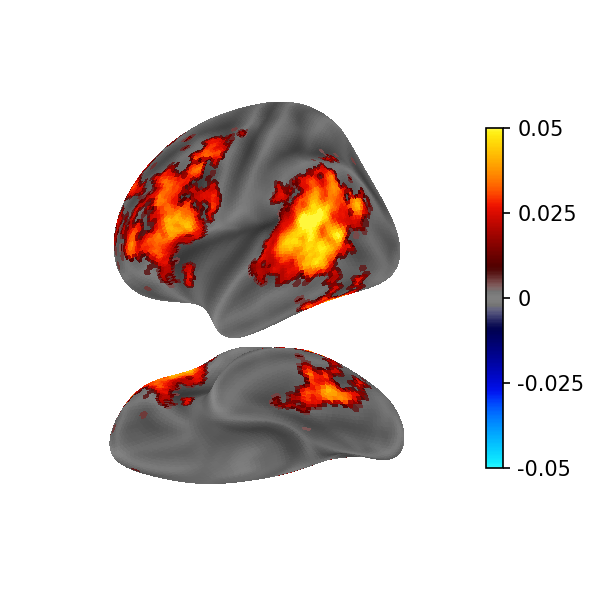

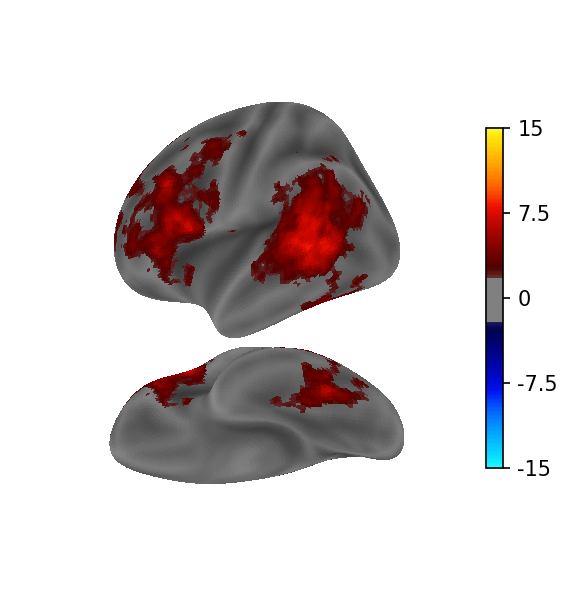

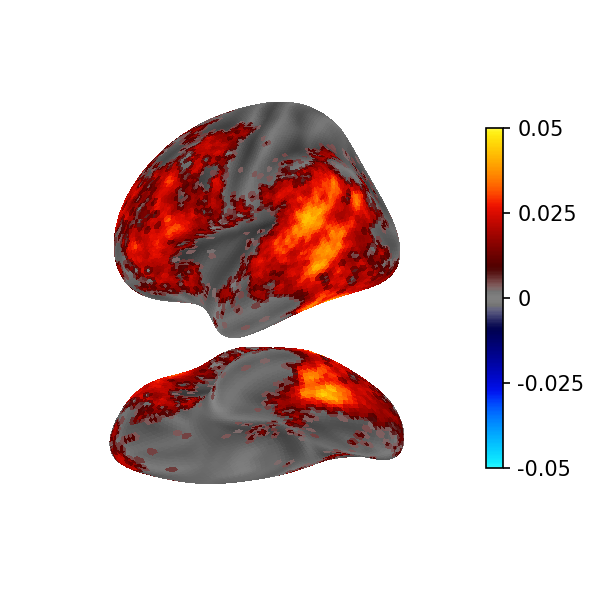

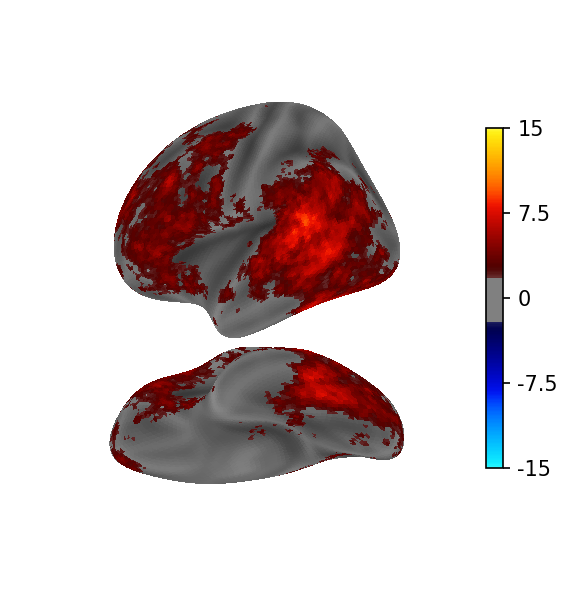

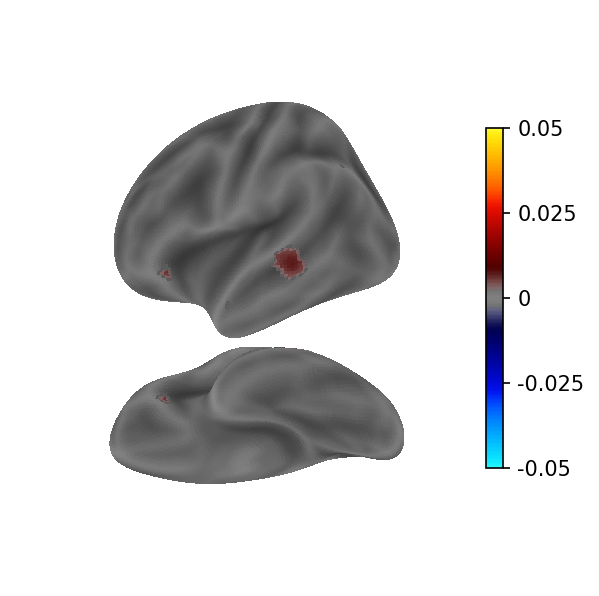

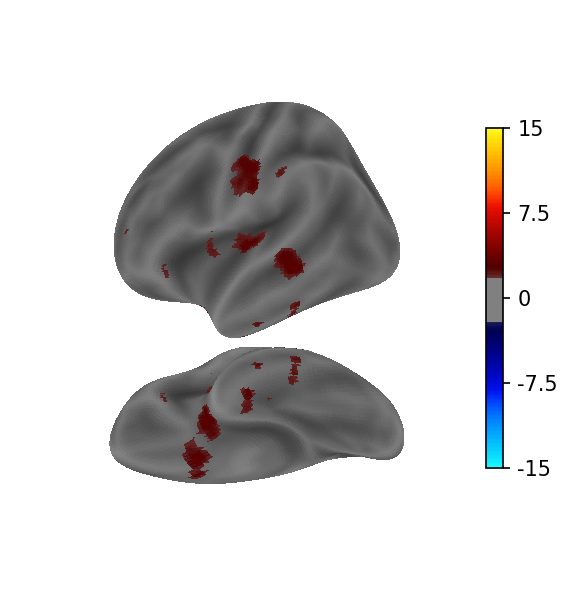

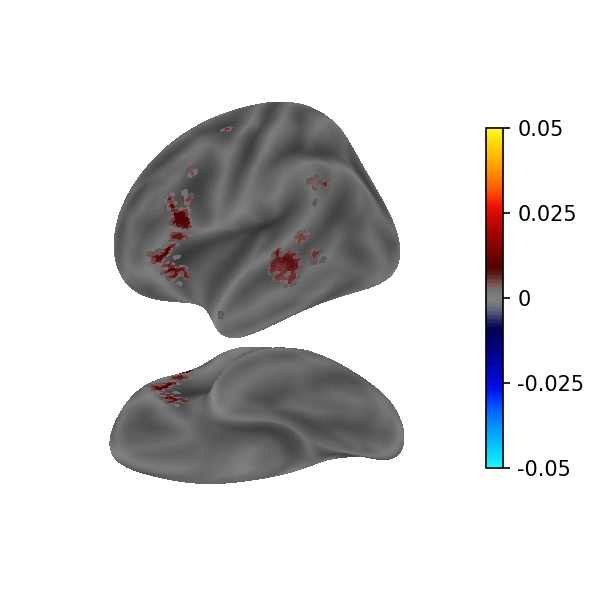

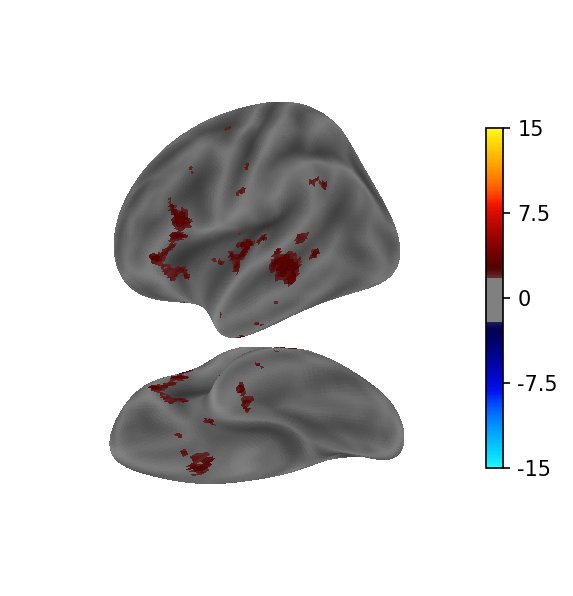

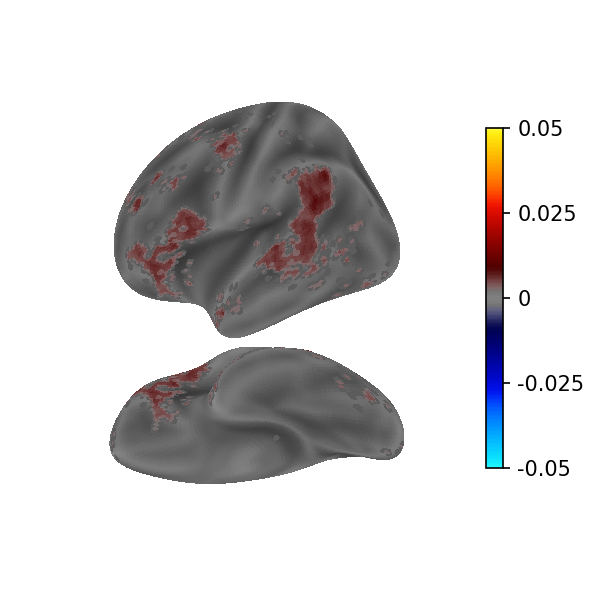

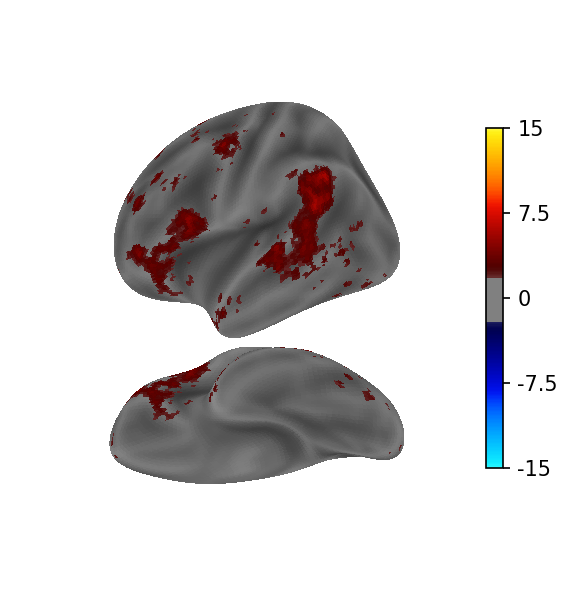

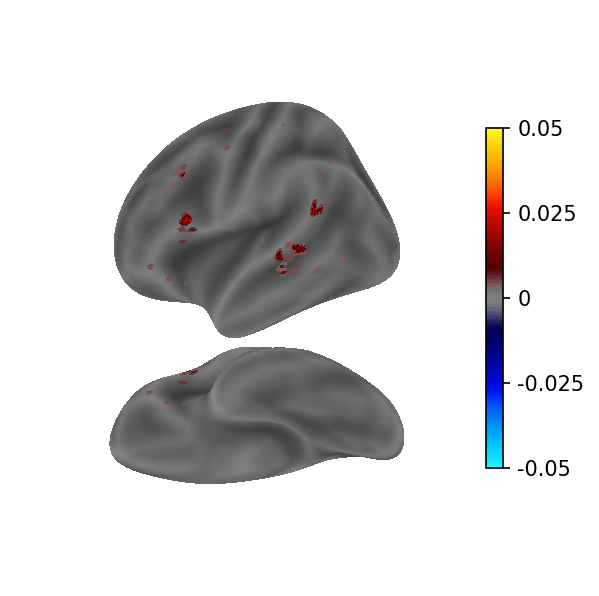

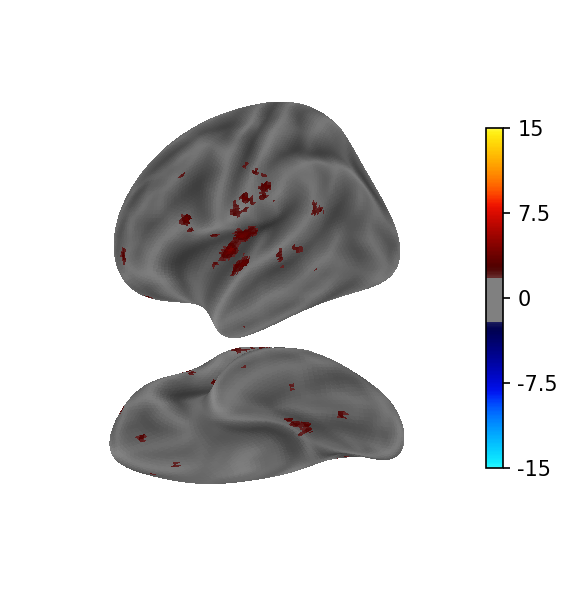

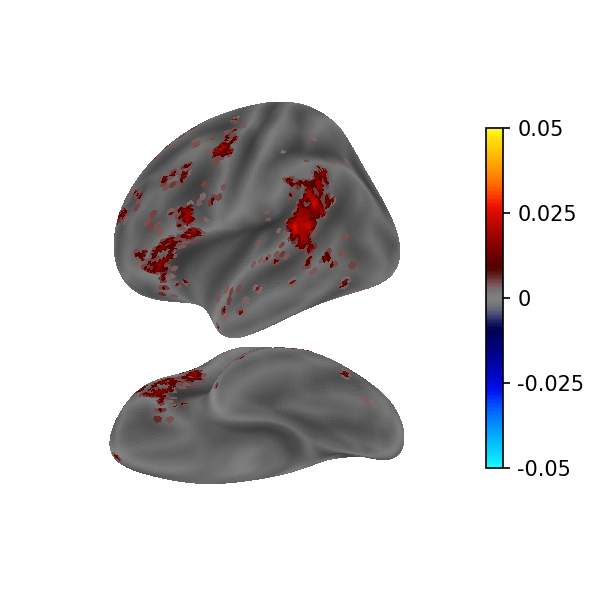

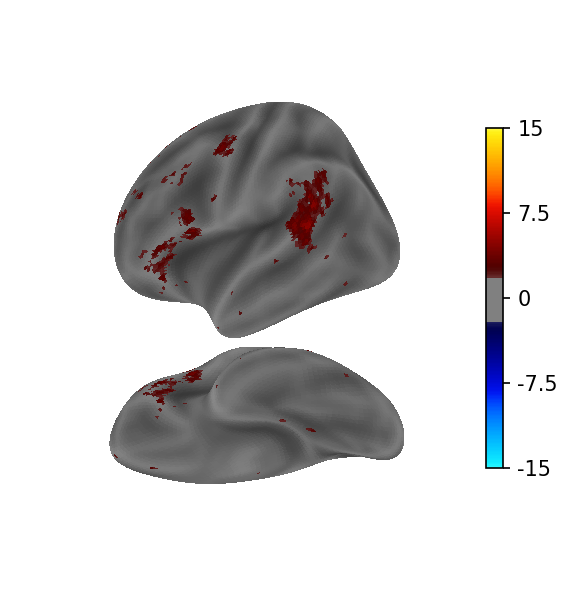

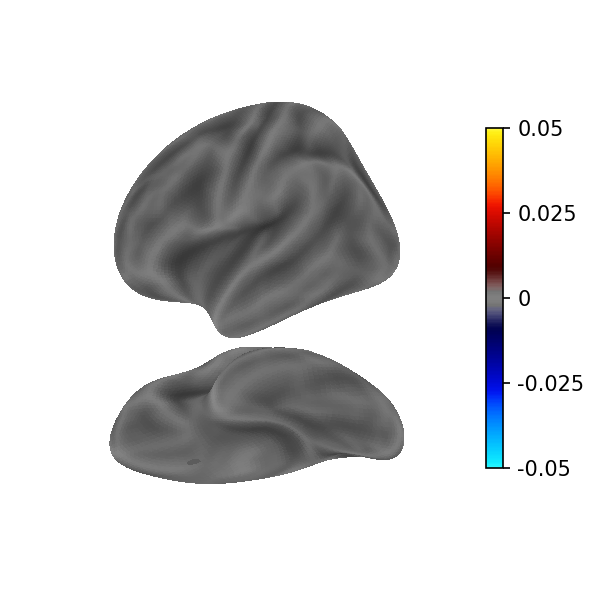

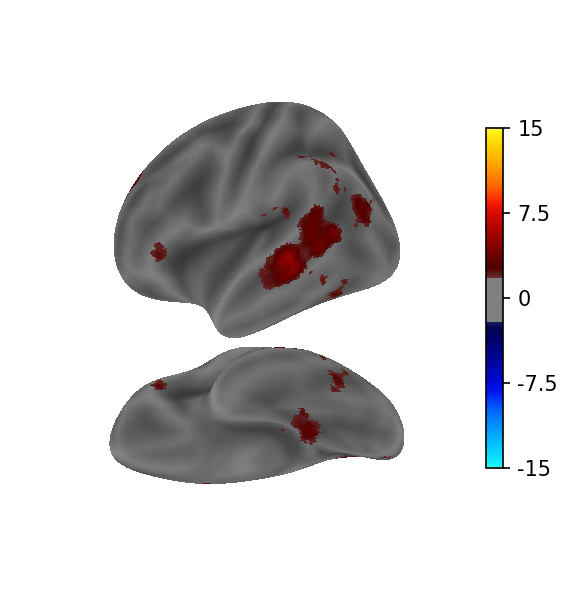

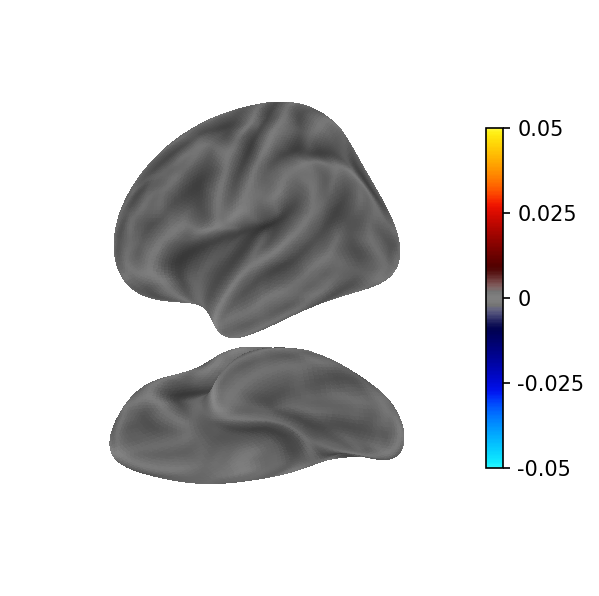

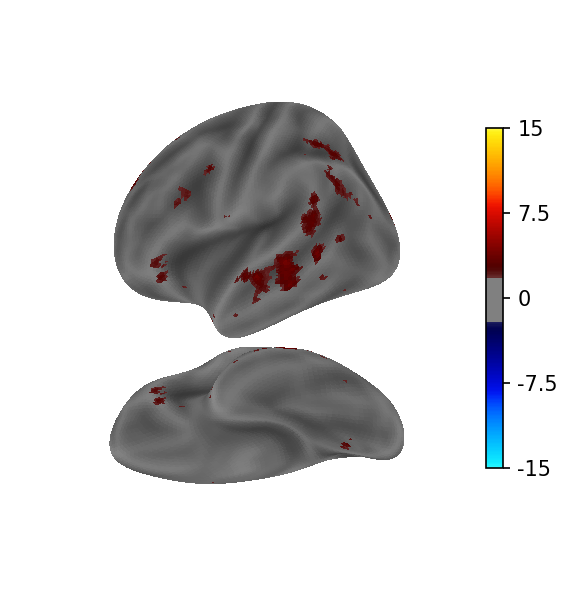

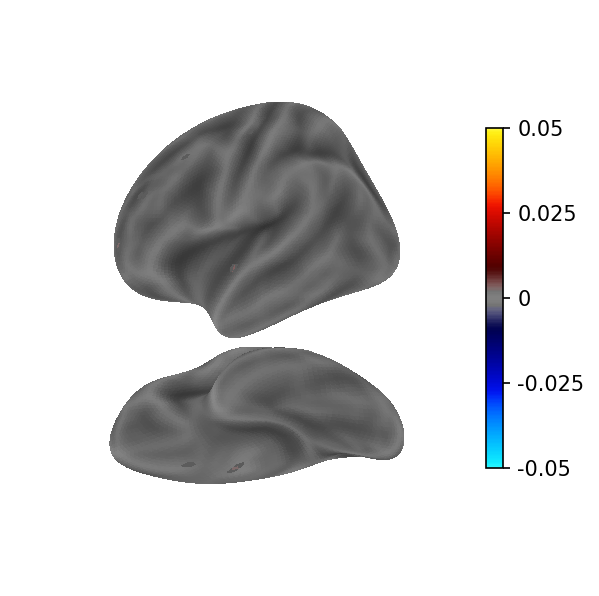

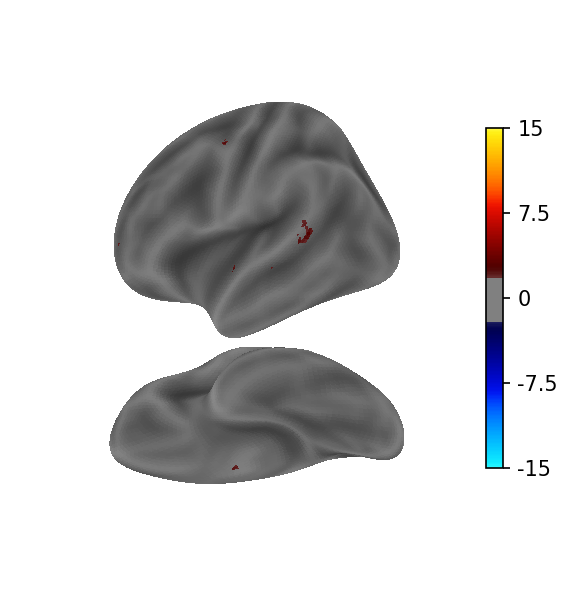

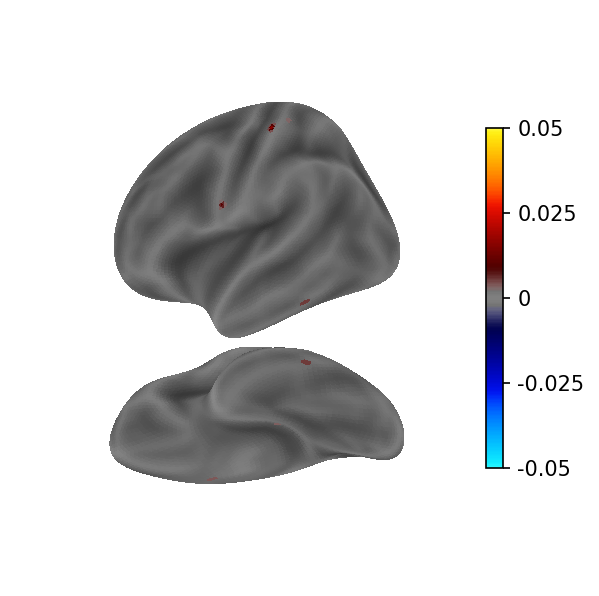

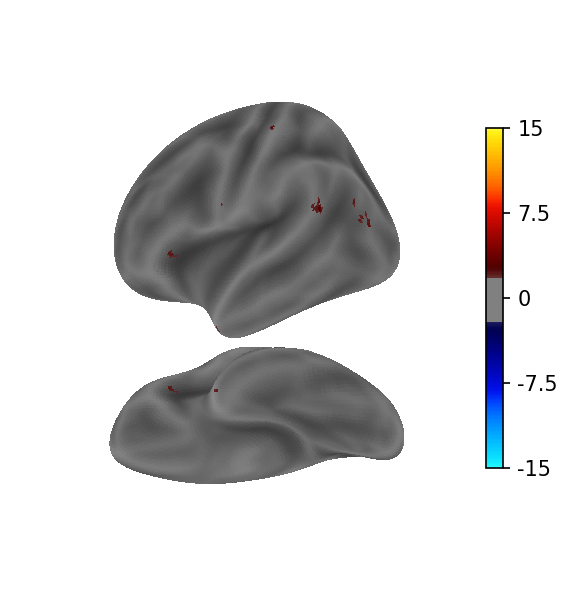

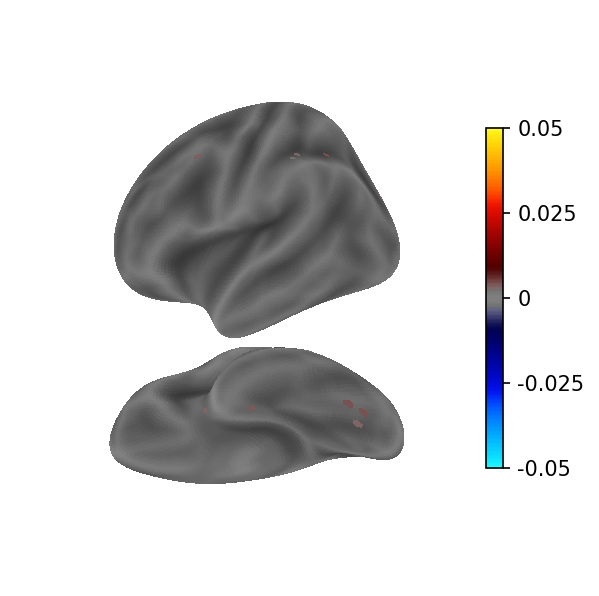

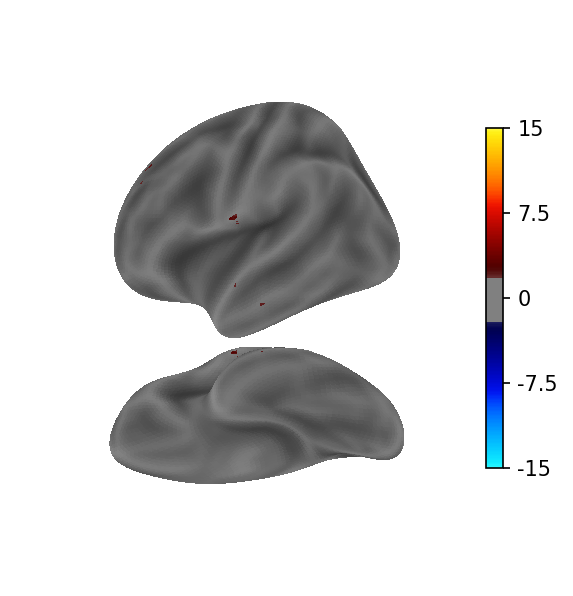

In [27]:
features = ('word_length', 'word_freq', 'word_function', 'dummy')
analyses = ['Forward', 'PLS', 'RegCCA', 'B2B']
analyses += ['B2B_CCALinearSVR',]# 'B2B_CCASVR']
        
imgs = dict()
for feature in features:
    print(feature)
    for analysis in analyses:
        
        hemi = 'left'
        key = '_'.join((analysis, hemi, feature, 'knockout'))
        X = np.array([d for d in results[key].values])
        X = np.nan_to_num(X)
        
        # p-values
        valid = np.nanstd(X, 0)>0
        p = np.ones(X.shape[1])
        _, p[valid] = np.transpose(list(map(wilcoxon, X.T[valid])))
        
        # only display r gain
        mean = np.nanmean(X, 0)
        values = mean * ((mean>0) * (p < .01))
        
        fig = plot(values, threshold=.0001, cmap=cmap,
                   vmax=.05 if feature != 'word' else 1.)
        imgs[key] = crop(fig_to_img(fig))
        
        fig = plot(-np.log10(p), threshold=2, vmax=15, cmap=cmap)
        imgs[key + '_pval'] = crop(fig_to_img(fig))

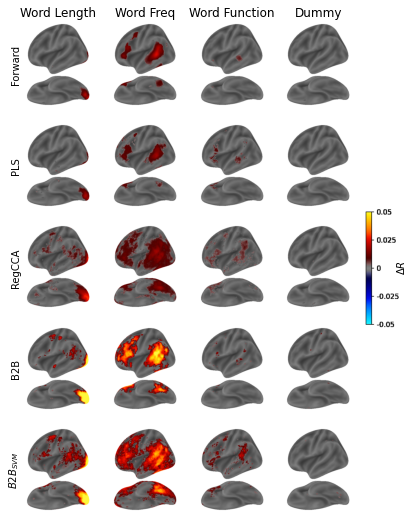

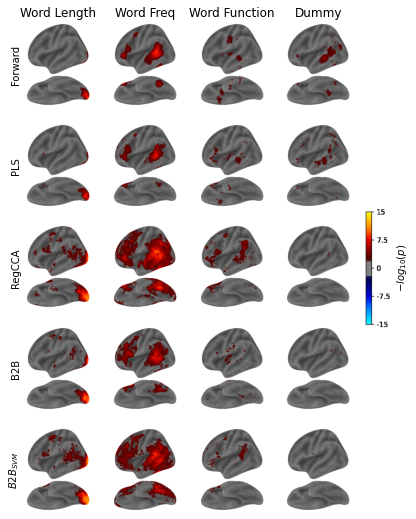

In [40]:
features = ('word_length', 'word_freq', 'word_function', 'dummy')
hemi = 'left'
for pval in [False, True]:
    fig = plt.figure(figsize=[7, 9], constrained_layout=False)
    gs = fig.add_gridspec(ncols=len(features)*2+1, nrows=len(analyses), wspace=0)
    axes = [[gs[r, (c*2):(c+1)*2] for c in range(len(features))] for r in range(len(analyses))]

    for analysis, axs in zip(analyses, axes):
        for feature, ax in zip(features, axs):

            ax = fig.add_subplot(ax)
            key = '_'.join((analysis, hemi, feature, 'knockout'))
            if pval:
                key += '_pval'
            img = imgs[key]
            colorbar = img[:, int(img.shape[1]*3.7/5):, :]
            img = img[:, :int(img.shape[1]*3.1/5), :]
            ax.imshow(img)
            for s in ('top', 'right', 'bottom', 'left'):
                ax.spines[s].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            if feature == features[0]:
                ylabel = analysis
                if ylabel == 'B2B_CCALinearSVR':
                    ylabel = '$B2B_{SVM}$'
                ax.set_ylabel(ylabel)
            if analysis == analyses[0]:
                ax.set_title(' '.join([w[0].upper() + w[1:] for w in feature.split('_')]))

    ax = fig.add_subplot(gs[:, -1])
    ax.imshow(colorbar)
    for s in ('top', 'right', 'bottom', 'left'):
        ax.spines[s].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if pval:
        ax.set_ylabel('$-log_{10}(p)$', labelpad=-10)
    else:
        ax.set_ylabel('$\Delta R$', labelpad=-10)
    ax.yaxis.set_label_position("right")
    if not pval:
        fig.savefig('fmri_delta_r.pdf', dpi=150, facecolor='white')
        fig.savefig('fmri_delta_r.png', dpi=150, facecolor='white')
    else:
        fig.savefig('fmri_pvals.pdf', dpi=150, facecolor='white')
        fig.savefig('fmri_pvals.png', dpi=150, facecolor='white')

# ROI

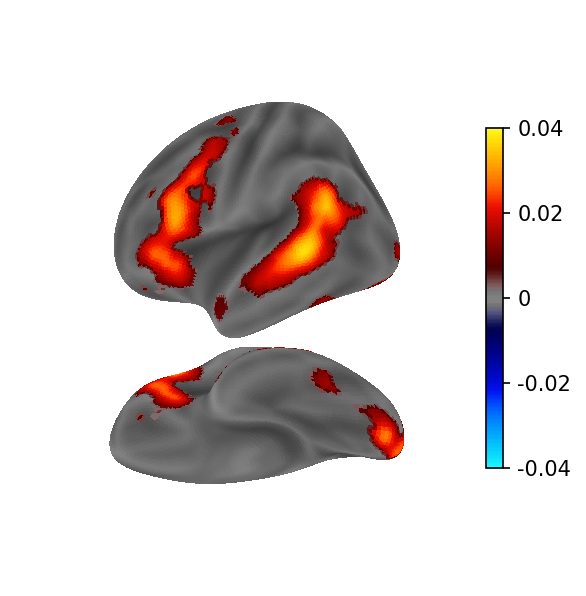

In [29]:
rois = dict()
for hemi in ('left',): #'right'
    analysis = 'Forward'

    key = '_'.join((analysis, hemi, feature))
    X = np.array([d for d in results[key].values])
    X = np.nan_to_num(X)

    # p-values
    valid = np.nanstd(X, 0)>0
    p = np.ones(X.shape[1])
    _, p[valid] = np.transpose(list(map(wilcoxon, X.T[valid])))
    
    rois[hemi] = p<.001
    
    # plot
    fig = plot(np.nanmean(X, 0) * (p<.001), threshold=0.001, 
               vmax=.04, cmap=cmap, hemi=hemi)
    roi_img = crop(fig_to_img(fig))

In [30]:
features = ('word_length', 'word_freq', 'word_function', 'dummy')
models = ('Forward', 'PLS', 'RegCCA', 'B2B', 'B2B_CCALinearSVR')
summary = list()
for feature in features:
    for model in models:
        scores = list()
        for hemi in ('left', ):
            key = '_'.join((model, hemi, feature, 'knockout'))
            scores.append([s[rois[hemi]] for s in results[key].values])
        scores = np.nanmean(np.concatenate(scores, axis=1), axis=1)
        for i, score in enumerate(scores):
            summary.append(dict(subject=i, r=score, model=model, feature=feature))
summary = pd.DataFrame(summary)

No handles with labels found to put in legend.


word_length: Forward versus B2B: 0.0000
word_length: PLS versus B2B: 0.0000
word_length: RegCCA versus B2B: 0.0000


No handles with labels found to put in legend.


word_length: B2B_CCALinearSVR versus B2B: 0.2298
word_freq: Forward versus B2B: 0.0000
word_freq: PLS versus B2B: 0.0000
word_freq: RegCCA versus B2B: 0.0000


No handles with labels found to put in legend.


word_freq: B2B_CCALinearSVR versus B2B: 0.2108
word_function: Forward versus B2B: 0.0138
word_function: PLS versus B2B: 0.0690
word_function: RegCCA versus B2B: 0.1073


No handles with labels found to put in legend.


word_function: B2B_CCALinearSVR versus B2B: 0.0244
dummy: Forward versus B2B: 0.7661
dummy: PLS versus B2B: 0.4453
dummy: RegCCA versus B2B: 0.9329
dummy: B2B_CCALinearSVR versus B2B: 0.2763


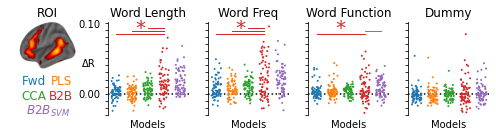

In [43]:
fig, axes = plt.subplots(1, len(features)+1, 
                         #sharex=True, sharey=True, 
                         figsize=[7, 2], facecolor='white')
axes[0].set_visible(False)

ax = fig.add_subplot(256)
ax.text(0, 2, 'Fwd', color='C0', horizontalalignment='center', fontsize=12)
ax.text(1, 2, 'PLS', color='C1', horizontalalignment='center', fontsize=12)
ax.text(0, 0, 'CCA', color='C2', horizontalalignment='center', fontsize=12)
ax.text(1, 0, 'B2B', color='C3', horizontalalignment='center', fontsize=12)
ax.text(.5, -2, '$B2B_{SVM}$', color='C4', horizontalalignment='center', fontsize=12)

ax.set_ylim(-2.1, 4)
ax.set_xlim(-1, 2)
ax.axis('off')
ax = fig.add_subplot(251)
ax.imshow(roi_img[9:249, 10:304])
ax.axis('off')
ax.set_title('ROI')

for feature, ax in zip(features, axes[1:]):
    d = summary.query('feature==@feature')
    sns.stripplot(x='model', y='r', data=d, jitter=.3, s=2, ax=ax)
    
    # legend clean up
    ax.axhline(0,color='k', ls=':')
    ax.legend().set_visible(False)
    
    ylim = .1
    ax.set_ylim(-.03, ylim)
    yticks = np.around(np.arange(-.03, .101, .01), 2)
    ax.set_yticks(yticks)
    if ax == axes[1]:
        ax.set_ylabel('ΔR', labelpad=-10).set_rotation(0)
        ax.set_yticklabels(np.around(yticks, 2))
        ax.set_yticklabels(['%.2f' % f if f in (0., .1) else '' 
                            for f in yticks])
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_title(' '.join([w[0].upper() + w[1:] for w in feature.split('_')]))
    ax.set_xlabel('Models')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # statistical comparison
    if feature == 'dummy':
        pass

    space = np.ptp(ax.get_ylim()) / 30
    k = 0
    for idx, m1 in enumerate(models):

        r = list()
        _, p = wilcoxon(d.query('model == @m1').r.values)
        # print('%s: %s: %.4f' % (feature, m1, p))
        
        for jdx, m2 in enumerate(models):
            if m1 == m2:
                continue
            if m2 != 'B2B': # _CCALinearSVR
                continue
            r = list()
            d.query('model==@m1').r.values
            for _, subject in d.query('model in [@m1, @m2]').groupby('subject'):
                if len(subject)==2:
                    r.append([subject.query('model==@m1').r.values[0],
                              subject.query('model==@m2').r.values[0]])
            r1, r2 = np.transpose(r)
            u, p = wilcoxon(r1, r2)
            print('%s: %s versus %s: %.4f' % (feature, m1, m2, p))
            if p < .05: # and 'B2B_CCALinearSVR' == m2:
                k += 1
                y = .8 * ylim + k * space
                if np.median(r1) > np.median(r2):
                    color = 'C%i' % idx
                else:
                    color = 'C%i' % jdx
                    
                ax.plot(np.linspace(0, 4, 5)[[idx, jdx]], 
                        [y, y], color=color, lw=1.)
    if k:
        ax.text(1.5, .085, '*', color='C3', fontsize=20, horizontalalignment='center')
    ax.set_ylim(-.03, .101)
fig.tight_layout(h_pad=0, w_pad=-1)

fig.savefig('fmri_strip.pdf', dpi=150, facecolor='white')
fig.savefig('fmri_strip.png', dpi=150, facecolor='white')

# Controls betas manova decod etc

# manova

In [32]:
# results_manova = pd.DataFrame([j.results()[0] for j in jobs_manova if j.state=='COMPLETED'])
# results_manova = pd.DataFrame([j.results()[0] for j in jobs_manova_small if j.state=='COMPLETED'])

In [33]:
# analysis = 'Manova_small'
# hemi = 'left'
# key = '_'.join((analysis, hemi, 'dummy'))

# for feature in ('word_length', 'word_freq', 'word_function', 'dummy'):
#     key = '_'.join((analysis, hemi, feature))
#     X = np.array([d for d in results[key].values])

#     X = np.nan_to_num(X)

#     # p-values
#     valid = np.nanstd(X, 0)>0
#     p = np.ones(X.shape[1])
#     _, p[valid] = np.transpose(list(map(wilcoxon, X.T[valid])))

#     # plot
#     fig = plot(-np.log10(p), threshold=3, vmax=13,
#                cmap=cmap, hemi=hemi)
#     imgs[key] = crop(fig_to_img(fig))

word_length
word_freq
word_function
dummy


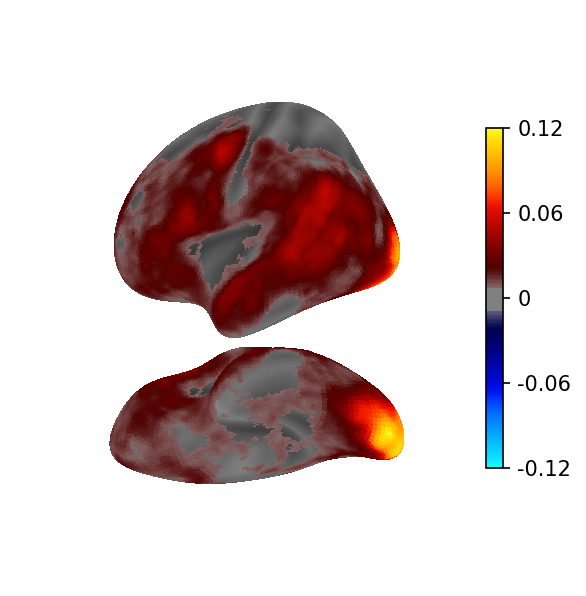

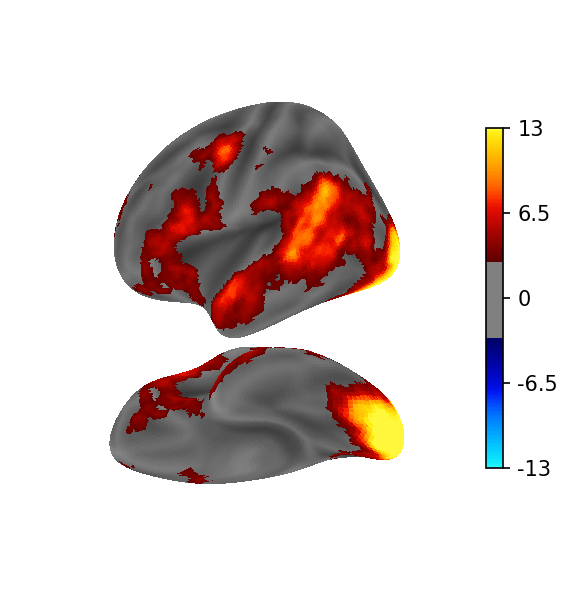

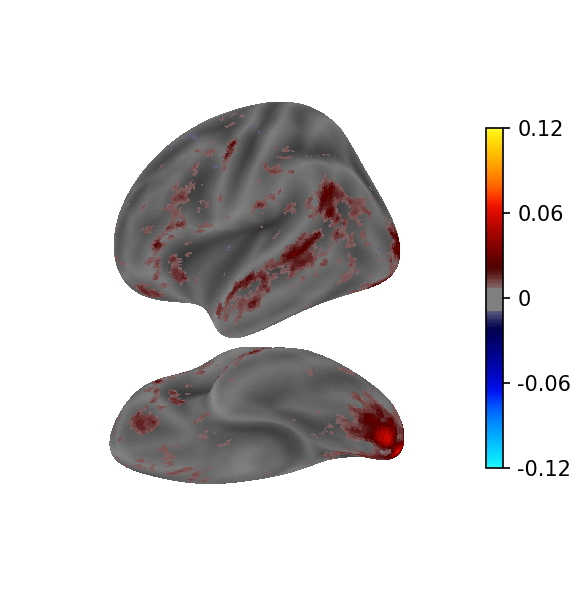

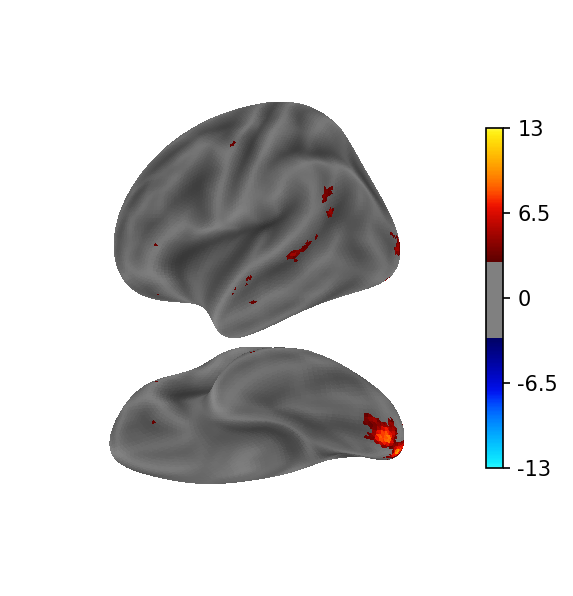

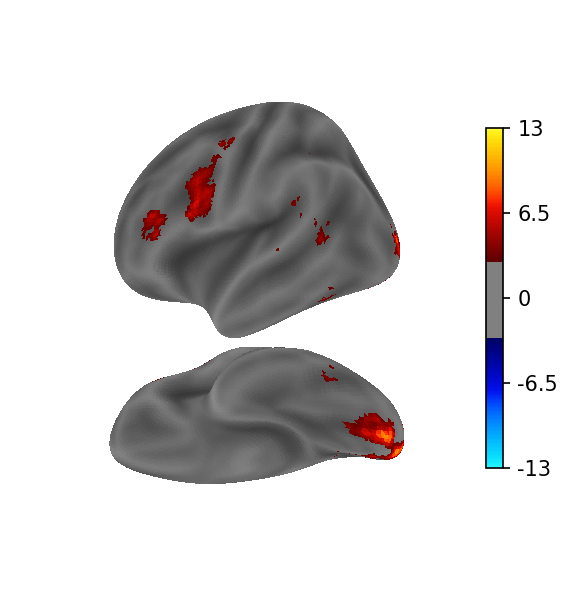

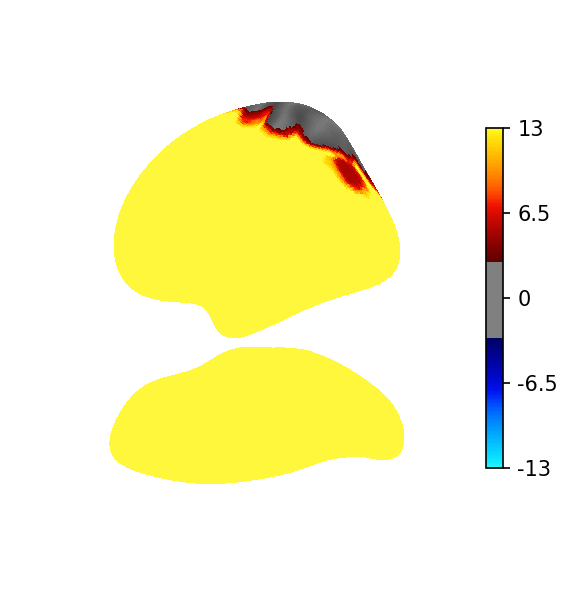

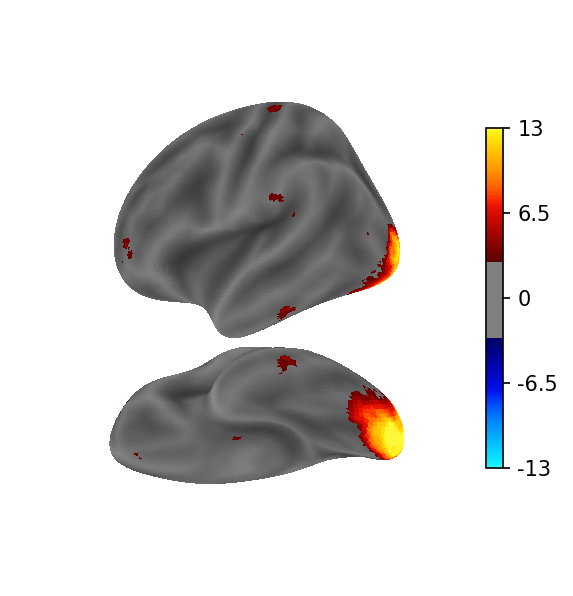

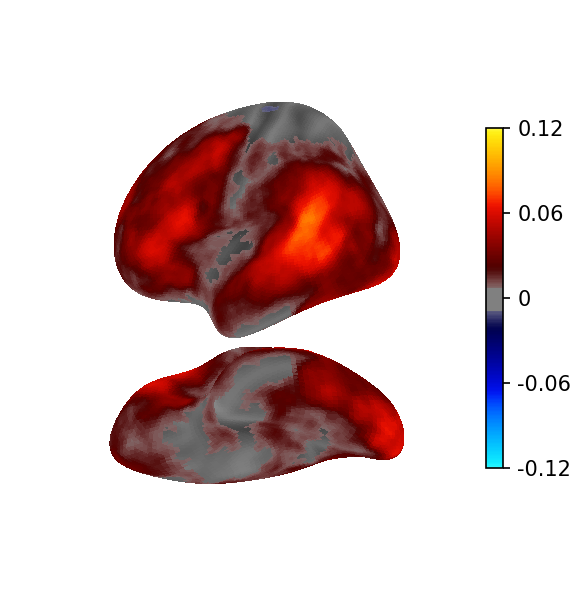

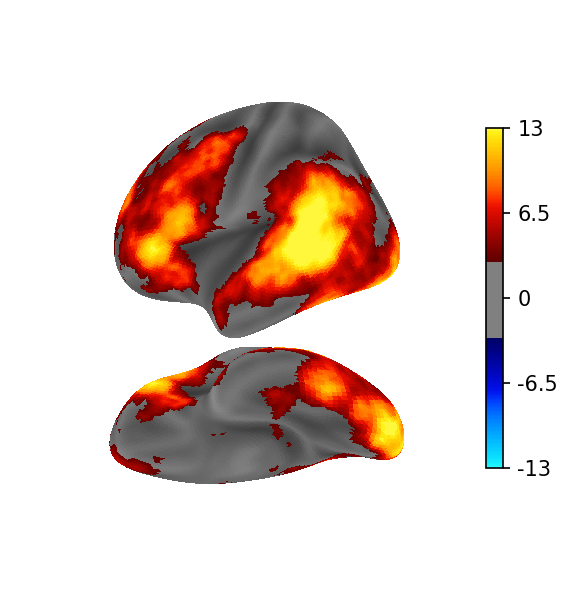

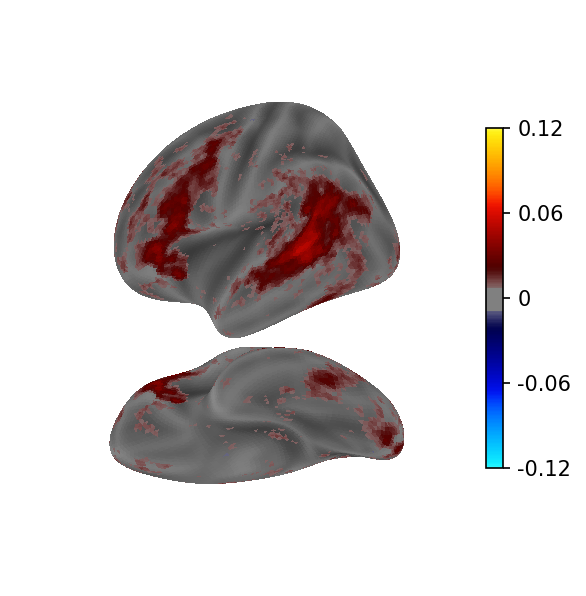

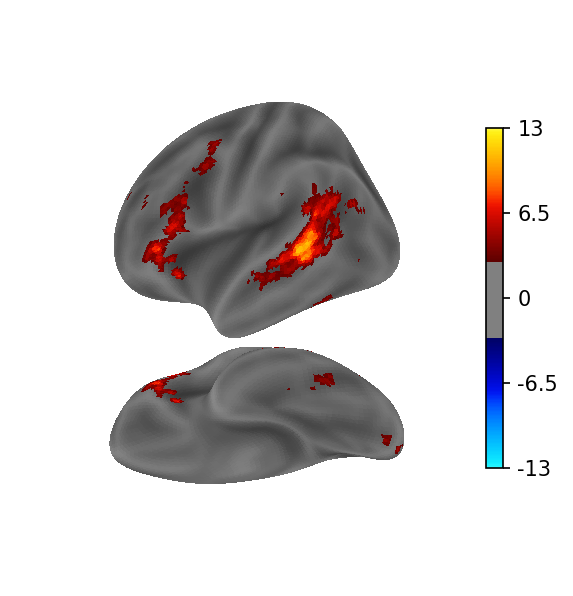

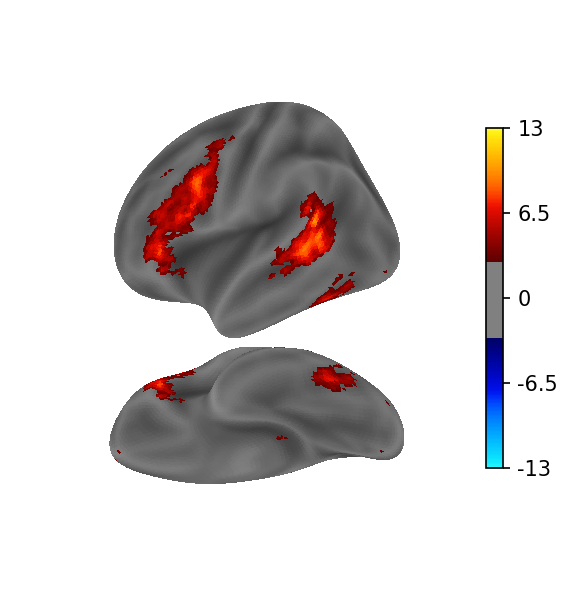

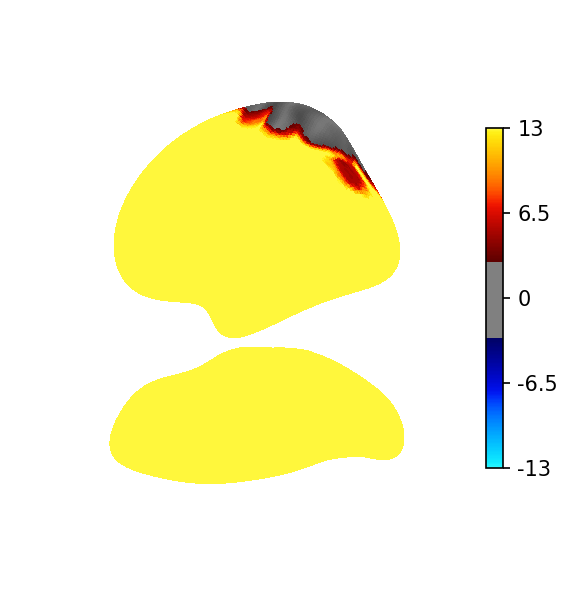

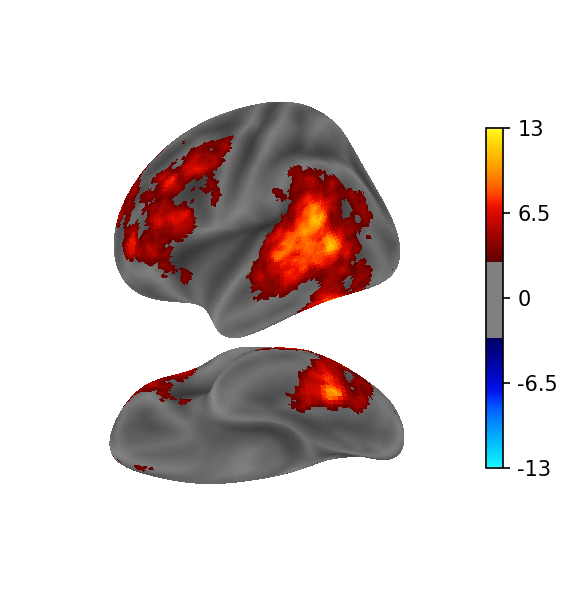

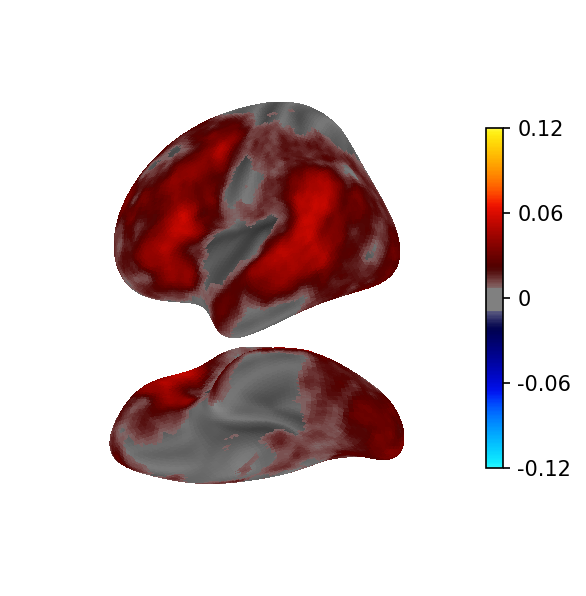

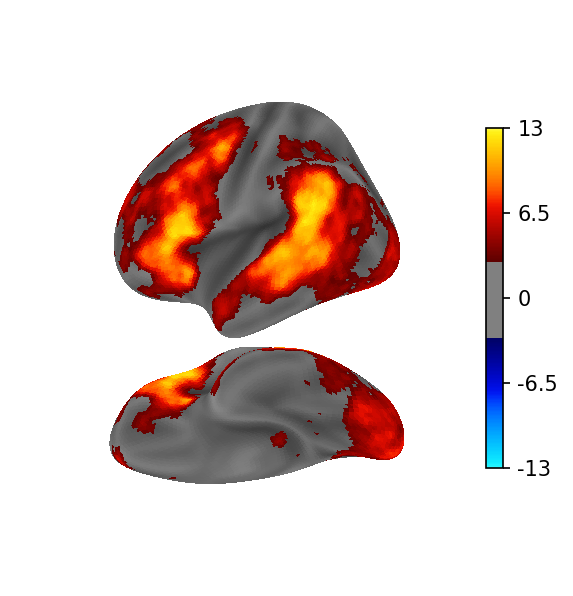

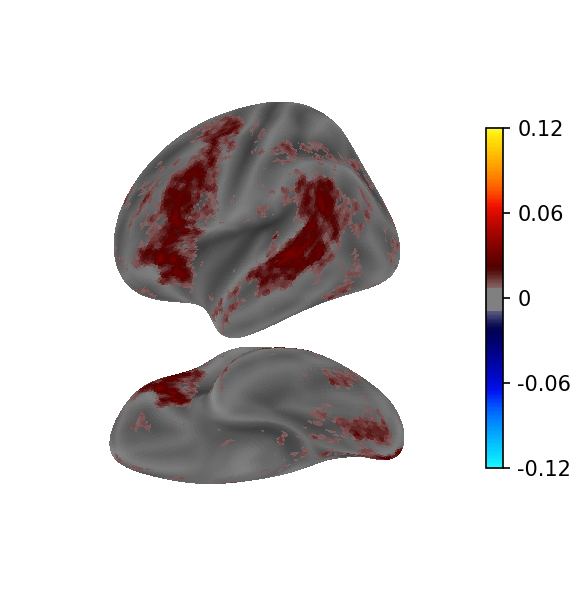

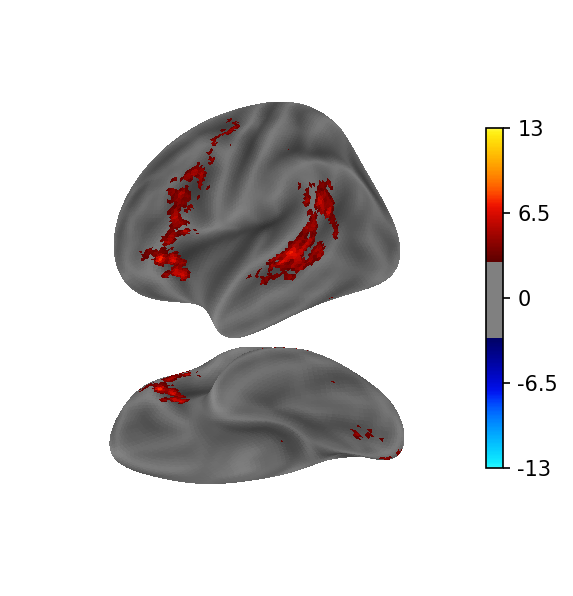

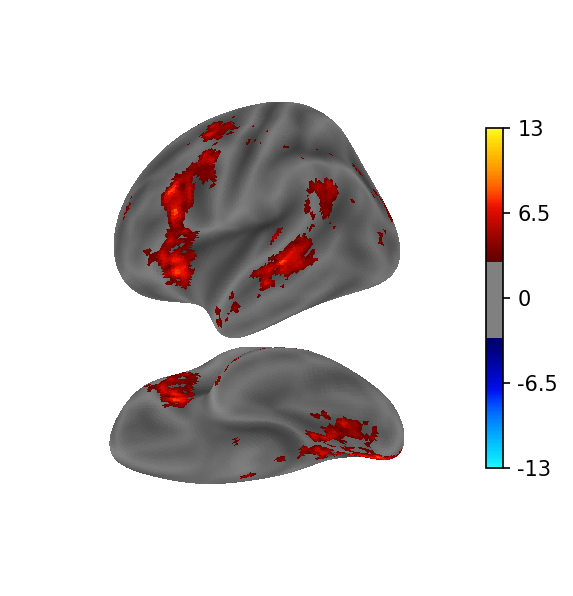

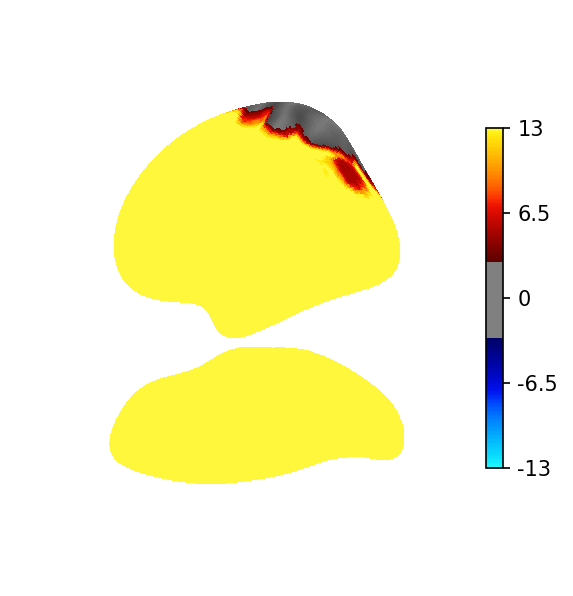

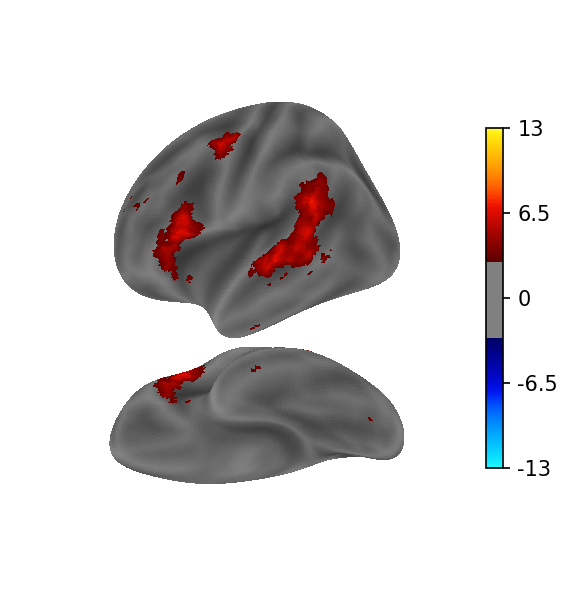

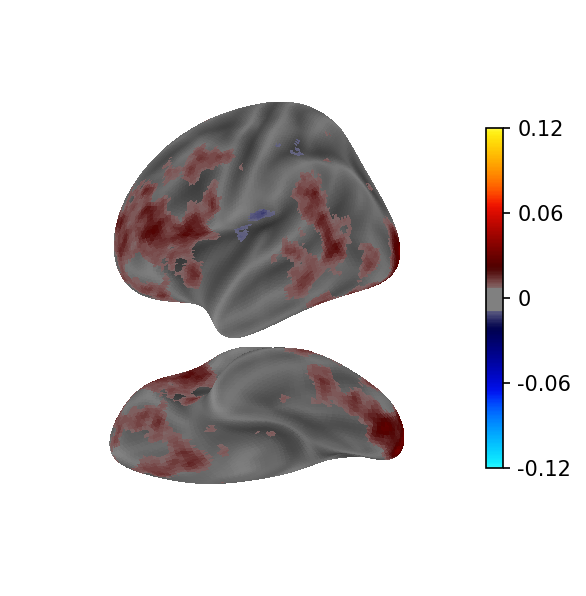

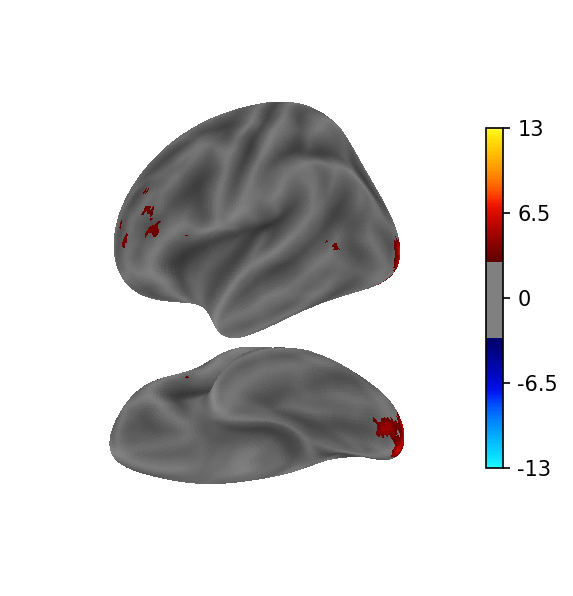

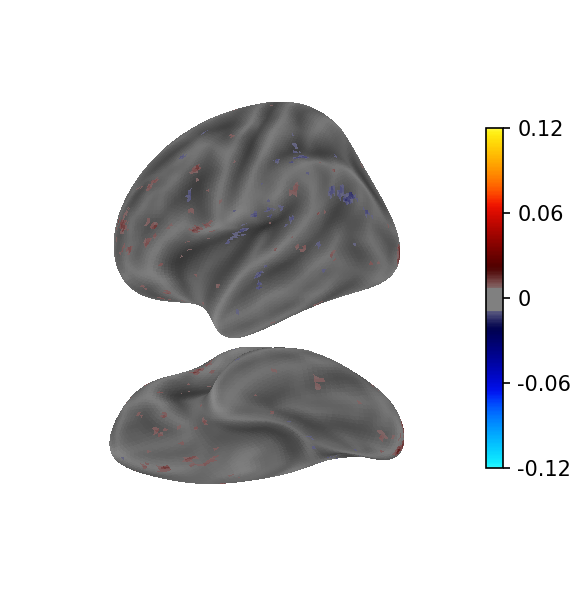

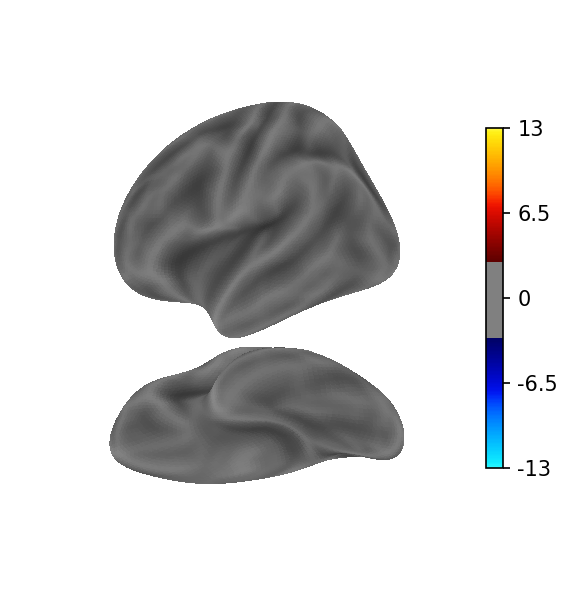

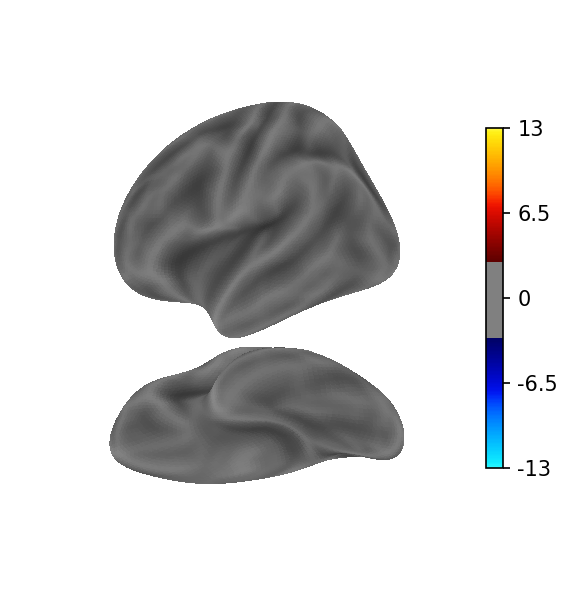

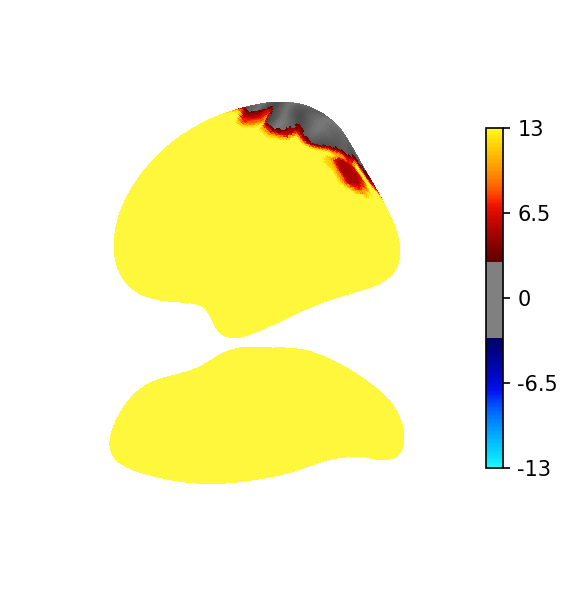

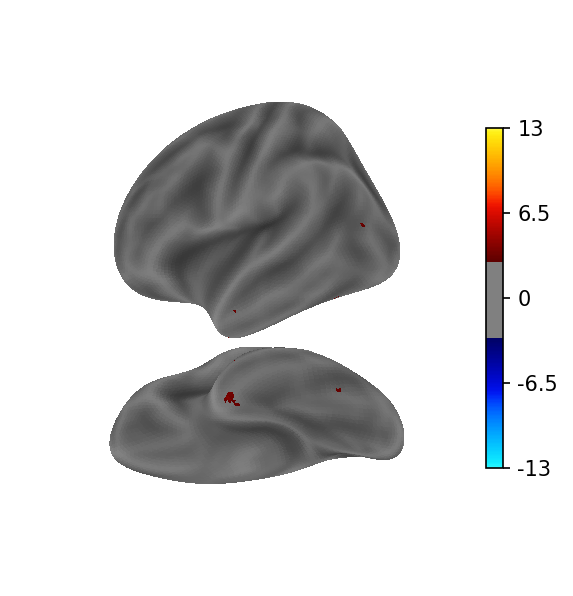

In [53]:
features = ['word_length', 'word_freq', 'word_function', 'dummy']
for feature in features:
    print(feature)
    for analysis in ('decod', 'encod', 'betas', 'Manova', 'UnbiasedB2B_betas'):
        
        hemi = 'left'
        key = '_'.join((analysis, hemi, feature))
        X = np.array([d for d in results[key].values])
        X = np.nan_to_num(X)
        
        vmax = .12
        if analysis in ('decod', 'encod', 'Forward', 'Backward'):
            fig = plot(np.clip(np.nanmean(X, 0), -vmax, vmax), 
                       threshold=0.008, vmax=vmax, cmap=cmap)
            imgs[key] = crop(fig_to_img(fig))
        
        # p-values
        valid = np.nanstd(X, 0)>0
        p = np.ones(X.shape[1])
        _, p[valid] = np.transpose(list(map(wilcoxon, X.T[valid])))
        
        fig = plot(np.clip(-np.log10(p), 0, 13), 
                   threshold=3, vmax=13, cmap=cmap)
        imgs[key + '_pval'] = crop(fig_to_img(fig))

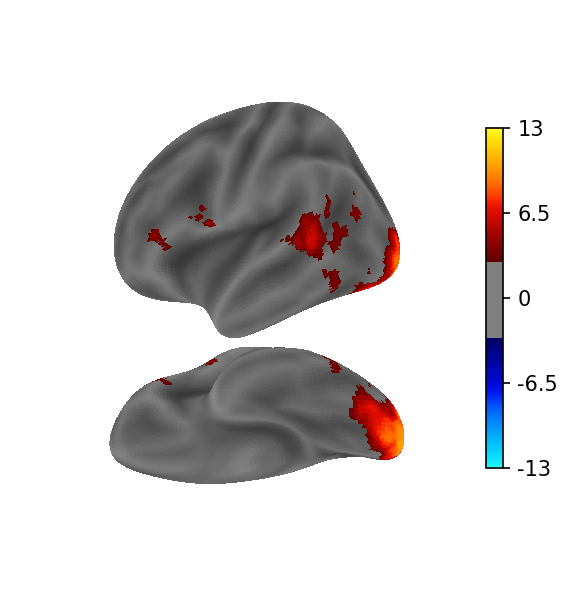

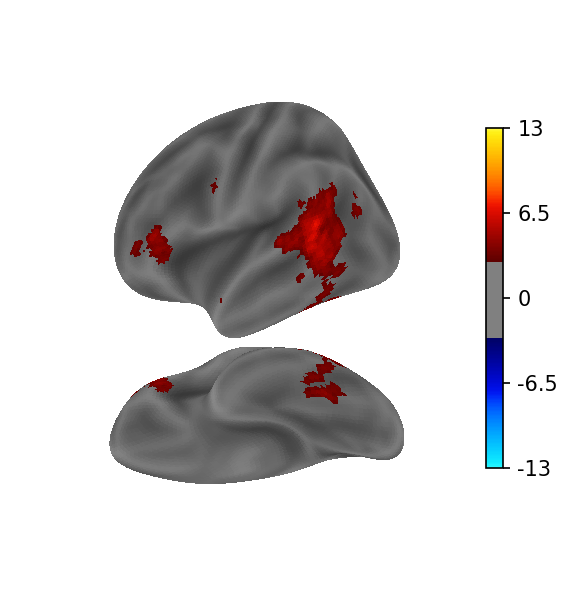

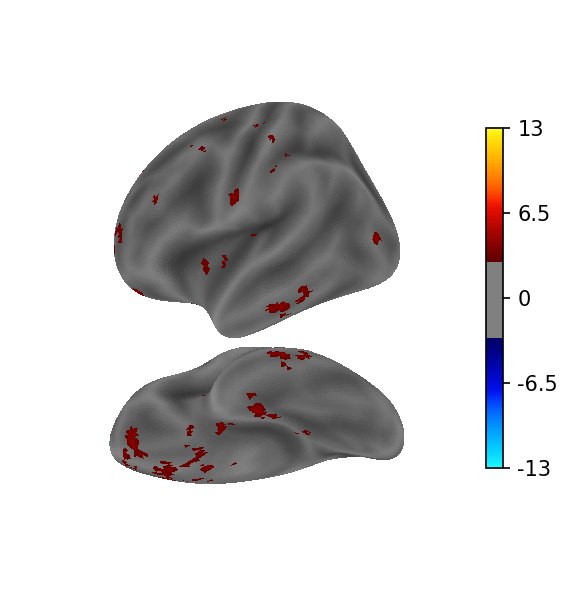

In [46]:
analysis = 'Manova'
hemi = 'left'
key = '_'.join((analysis, hemi, 'dummy'))
dummy = np.array([d for d in results[key].values])

for feature in ('word_length', 'word_freq', 'word_function'):
    key = '_'.join((analysis, hemi, feature))
    X = np.array([d for d in results[key].values])

    X = np.nan_to_num(X - dummy)

    # p-values
    valid = np.nanstd(X, 0)>0
    p = np.ones(X.shape[1])
    _, p[valid] = np.transpose(list(map(wilcoxon, X.T[valid])))

    # plot
    fig = plot(np.clip(-np.log10(p), 0, 13), 
               threshold=3, vmax=13, cmap=cmap)
    imgs['dummy_vs_' + key + '_pval'] = crop(fig_to_img(fig))        

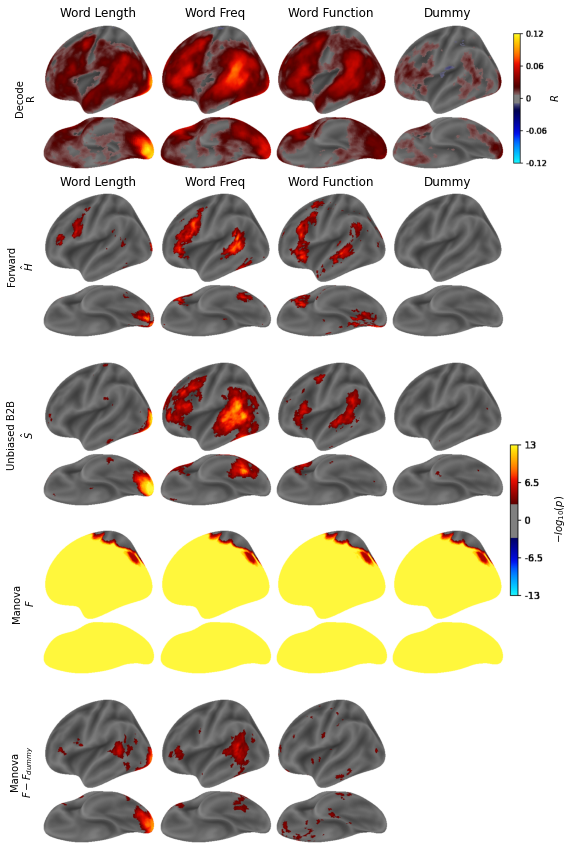

In [55]:
analyses = ('decod',
            'betas', 'UnbiasedB2B_betas', 
            'Manova',  'dummy_vs_Manova')
analysis_names = dict(
    Backward='Decode\nR',
    decod='Decode\nR',
    encod='Encod 1 Feature\nR',
    betas='Forward\n$\hat H$',
    Manova='Manova\n$F$',
    UnbiasedB2B_betas='Unbiased B2B\n$\hat S$',
    #B2B='B2B\n$\Delta R$',
    dummy_vs_Manova='Manova\n$F - F_{dummy}$',

)
features = ['word_length', 'word_freq', 'word_function', 'dummy']

fig = plt.figure(figsize=[8, 12], constrained_layout=False)

gs = fig.add_gridspec(ncols=2*len(features)+1, 
                      nrows=len(analyses), 
                      wspace=0)
axes = iter([[gs[r, (c*2):(c+1)*2] 
             for c in range(len(features))]
             for r in range(len(analyses))])
c_axes = [fig.add_subplot(gs[:1, -1]),
          fig.add_subplot(gs[2:4, -1])]

group_analyses = (
    ('decod', ),
    ('betas', 'UnbiasedB2B_betas',
     'Manova', 'dummy_vs_Manova'),
)

for group, analyses_ in enumerate(group_analyses):
    for analysis in analyses_:
        axs = next(axes)
        for feature, ax in zip(features, axs):
            if analysis == 'dummy_vs_Manova' and feature == 'dummy':
                continue

            ax = fig.add_subplot(ax)
            key = '_'.join((analysis, hemi, feature))
            if analysis == 'B2B':
                key += '_knockout'
            if group == 1:
                key += '_pval'
                cmap_label = '$-log_{10}(p)$'
            else:
                cmap_label = '$R$'
                
            img = imgs[key]
            colorbar = img[:, int(img.shape[1]*3.7/5):, :]
            img = img[:, :int(img.shape[1]*3.1/5), :]
            ax.imshow(img)
            for s in ('top', 'right', 'bottom', 'left'):
                ax.spines[s].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            if feature == features[0]:
                ax.set_ylabel(analysis_names[analysis])
            if analysis == analyses_[0]:
                ax.set_title(' '.join([w[0].upper() + w[1:] for w in feature.split('_')]))

    ax = c_axes[group]
    ax.imshow(colorbar)
    for s in ('top', 'right', 'bottom', 'left'):
        ax.spines[s].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(cmap_label, labelpad=-10)
    ax.yaxis.set_label_position("right")

fig.tight_layout(w_pad=0, h_pad=.01)
fig.savefig('fmri_controls.pdf', dpi=150, facecolor='white')
fig.savefig('fmri_controls.png', dpi=150, facecolor='white')

# all vertices

In [49]:
features = ['word_length', 'word_freq', 'dummy']
analyses = ['Forward', 'PLS', 'RegCCA', 'CCA', 'B2B']

summary = list()
for feature in features:
    for analysis in analyses:
        scores = list()
        for hemi in ('left', 'right'):
            key = '_'.join((analysis, hemi, feature, 'knockout'))
            scores.append(np.array([d for d in results[key].values]))
        scores = np.concatenate(scores, axis=1)
        scores = np.nanmean(scores, axis=1)
        
        for subject, s in enumerate(scores):
            summary.append(dict(feature=feature, analysis=analysis, score=s, subject=subject))
summary = pd.DataFrame(summary)

In [50]:
summary = list()
for feature in features:
    for analysis in analyses:
        scores = list()
        for hemi in ('left', 'right'):
            key = '_'.join((analysis, hemi, feature, 'knockout'))
            scores.append(np.array([d for d in results[key].values]))
        scores = np.concatenate(scores, axis=1)
        scores = np.nanmean(scores, axis=0)
        
        for vertex, s in enumerate(scores):
            summary.append(dict(feature=feature, analysis=analysis, score=s, vertex=vertex))
summary = pd.DataFrame(summary)

/private/home/jeanremi/.conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [69]:
summary = list()
for feature in features:
    print(feature)
    for analysis in analyses:
        scores = list()
        for hemi in ('left', 'right'):
            key = '_'.join((analysis, hemi, feature, 'knockout'))
            scores.append(np.array([d for d in results[key].values]))
        scores = np.concatenate(scores, axis=1)
        
        p_vals = np.ones(scores.shape[1])
        for idx, s in enumerate(scores.T):
            valid = ~np.isnan(s)
            if not sum(valid):
                continue
            _, p_vals[idx] = wilcoxon(s[valid])
            
        for vertex, p in enumerate(p_vals):
            summary.append(dict(feature=feature, analysis=analysis, p=p, vertex=vertex))
summary = pd.DataFrame(summary)

word_length


/private/home/jeanremi/.conda/envs/covid/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


word_freq
dummy


In [70]:
import seaborn as sns

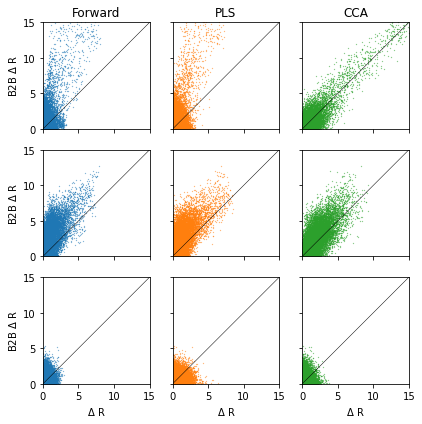

In [71]:
fig, axes = plt.subplots(len(features), 3, sharey=True, sharex=True, figsize=[6, 6])
for feature, axs in zip(features, axes):
    for c, (analysis, ax) in enumerate(zip(('Forward', 'PLS', 'CCA'), axs)):
        y = -np.log10(summary.query('analysis=="B2B" and feature==@feature').p)
        x = -np.log10(summary.query('analysis==@analysis and feature==@feature').p)
        ax.scatter(x, y, s=.05, color='C%i' % c)
        ax.plot([0, 15], [0, 15], 'k', lw=.5)
        ax.set_xlim([0, 15])
        ax.set_ylim([0, 15])
        ax.set_aspect('equal')
        if feature == features[0]:
            ax.set_title(analysis)
        elif feature == features[-1]:
            ax.set_xlabel('$\Delta$ R')
        if c == 0:
            ax.set_ylabel('B2B $\Delta$ R')
        
fig.tight_layout()

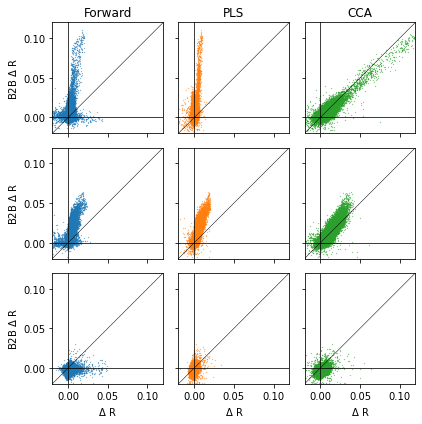

In [64]:
fig, axes = plt.subplots(len(features), 3, sharey=True, sharex=True, figsize=[6, 6])
for feature, axs in zip(features, axes):
    for c, (analysis, ax) in enumerate(zip(('Forward', 'PLS', 'CCA'), axs)):
        y = summary.query('analysis=="B2B" and feature==@feature').score
        x = summary.query('analysis==@analysis and feature==@feature').score
        ax.scatter(x, y, s=.05, color='C%i' % c)
        ax.plot([-1, 1], [-1, 1], 'k', lw=.5)
        ax.set_xlim([-.02, .12])
        ax.axhline(0, color='k', lw=.5)
        ax.axvline(0, color='k', lw=.5)
        ax.set_ylim([-.02, .12])
        ax.axhline(0, color='k', lw=.5)
        ax.axvline(0, color='k', lw=.5)
        ax.set_aspect('equal')
        if feature == features[0]:
            ax.set_title(analysis)
        elif feature == features[-1]:
            ax.set_xlabel('$\Delta$ R')
        if c == 0:
            ax.set_ylabel('B2B $\Delta$ R')
        
fig.tight_layout()

# Old Averages

In [24]:
def plot(left, right, views=3, threshold=None, **kwargs):
    if views == 3:
        fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=[11, 3])
        axes = dict(left=axes[:2], right=axes[[2, 1]])
    else:
        fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=[7, 3])
        axes = dict(left=axes[:2], right=[None, axes[1]])
    
    for hemi, data in dict(left=left, right=right).items():
        
        coords, verts = surface.load_surf_mesh(fsaverage['infl_%s' % hemi])
        side = -1 if hemi == 'left' else 1
        coords[:, 0] += side * coords[:, 0].max()
        
        opt = dict(threshold=threshold,
                   colorbar=False,
                   surf_mesh=(coords, verts),
                   bg_map=fsaverage['sulc_%s' % hemi])
        for k, v in kwargs.items():
            opt[k] = v
        if axes[hemi] is not None:
            plotting.plot_surf_stat_map(stat_map=data, hemi=hemi, axes=axes[hemi][0], **opt)
            axes[hemi][0].set_xlim(-83, 83)
            axes[hemi][0].set_ylim(-108, 108)
            axes[hemi][0].set_zlim(-73, 73)
        plotting.plot_surf_stat_map(stat_map=data, view='posterior', axes=axes[hemi][1], **opt)
        axes[hemi][1].set_xlim(-83, 83)
        axes[hemi][1].set_ylim(-108, 108)
        axes[hemi][1].set_zlim(-73, 73)
        
    fig.tight_layout(w_pad=0)
    return fig

def get_pvals(analysis, key, hemis=('left', 'right')):
    p_vals = list()
    for hemi in hemis:
        X = np.array([d for d in results['_'.join((analysis, hemi, key))].values])
        valid = X.std(0)>0
        p = np.ones(X.shape[1])
        r, p[valid] = np.transpose(list(map(wilcoxon, X.T[valid])))
        p_vals.append(-np.log10(p))
    return p_vals

# check fmriprep SLURM

In [96]:
ls /private/home/jeanremi/data/mous/freesurfer -halt

total 512
drwxrwxr-x 10 jeanremi jeanremi  0 May  9 06:48 sub-V1017/
drwxrwxr-x  1 jeanremi jeanremi  0 May  9 06:48 ./
drwxrwxr-x 10 jeanremi jeanremi  0 May  8 12:57 sub-V1006/
drwxrwxr-x  1 jeanremi jeanremi  0 Mar 17 01:34 ../
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 31  2019 morph-maps/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2096/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2091/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2108/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2101/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2094/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2092/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2103/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2106/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2095/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2110/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2105/
drwxrwxr-x  1 jeanremi jeanremi  0 Oct 29  2019 sub-A2099/
d

In [18]:
import os
import pandas as pd
failed = [f for f in os.listdir('jobs') if f.endswith('.err')]

df = list()
for job in failed:
    with open('jobs/' + job) as f:

        
        err = '\n'.join(f.readlines())
        if 'fMRIPrep finished without errors' in err:
        success = True
        err_type = ''
    else:
        success = False
        if 'DUE TO TIME LIMIT' in err:
            err_type = 'time'
        elif err == '':
            err_type = 'unknown'
        elif 'fmriprep: error: argument' in err:
            err_type = 'not subject'
    
    with open('jobs/' + job.replace('.err', '.out')) as f:
        out = '\n'.join(f.readlines())
        try:
            start = out.split('200509-')[1].split(',')[0]
            stop = out.split('200509-')[-2].split(',')[0]
        except IndexError:
            start, stop = None, None
        task_subject = out.split('task ')[1].split('\n')[0]
        try:
            task, subject = task_subject.split()
        except ValueError:
            task = task_subject
            subject = None
    
    df.append(dict(job=job,
                   success=success, 
                   err_type=err_type, 
                   task=task, 
                   subject=subject,
                   start=start, stop=stop))
df = pd.DataFrame(df)
df

job  success     err_type task    subject start  stop
0    26296043_0_log.err     True                 1  sub-V1001  None  None
1    26296046_0_log.err     True                 4  sub-V1004  None  None
2    26296048_0_log.err     True                 6  sub-V1006  None  None
3    26296047_0_log.err     True                 5  sub-V1005  None  None
4    26296049_0_log.err     True                 7  sub-V1007  None  None
..                  ...      ...          ...  ...        ...   ...   ...
105  26296432_0_log.err    False  not subject  103       None  None  None
106  26296436_0_log.err    False  not subject  107       None  None  None
107  26296437_0_log.err    False  not subject  108       None  None  None
108  26296041_0_log.err    False  not subject  110       None  None  None
109  26296438_0_log.err    False  not subject  109       None  None  None

[110 rows x 7 columns]

In [21]:
print(df.query('not success'))
print(len(df.query('success')))

                    job  success     err_type task    subject start  stop
12   26296058_0_log.err    False      unknown   16  sub-V1017  None  None
20   26296071_0_log.err    False      unknown   29  sub-V1033  None  None
21   26296066_0_log.err    False      unknown   24  sub-V1028  None  None
26   26296069_0_log.err    False      unknown   27  sub-V1031  None  None
43   26296104_0_log.err    False      unknown   62  sub-V1073  None  None
49   26296095_0_log.err    False      unknown   53  sub-V1063  None  None
53   26296093_0_log.err    False      unknown   51  sub-V1061  None  None
60   26296100_0_log.err    False      unknown   58  sub-V1069  None  None
69   26296135_0_log.err    False      unknown   93  sub-V1107  None  None
72   26296136_0_log.err    False      unknown   94  sub-V1108  None  None
75   26296127_0_log.err    False      unknown   85  sub-V1099  None  None
76   26296138_0_log.err    False      unknown   95  sub-V1109  None  None
90   26296140_0_log.err    False      